#  The association of clinical factors, sex and age with blood-based immune phenotypes 

This analysis explores how clinical variables, sex, and age relate to immune phenotypes derived from blood samples. Using output from AliGater, which includes event counts, percentages of target populations within parent populations, we aim to uncover meaningful associations.

By integrating this phenotypic data with clinical data including age and sex, we will assess how these factors influence immune profiles.

**The analysis here will try to answer the following questions:**

1) Batch Effects & Technical Robustness Are there batch effects or technical inconsistencies in flow cytometry data, given that samples were collected on different dates and processed within 36 hours of blood draw?

2) Phenotype Distributions What is the distribution of immune cell phenotypes across the dataset?

3) Clinical Associations How are clinical factors, sex, and age associated with immune phenotypes? **See multiple linear regression modeling in R. "/home/wenxiaren/Data_Analysis_and_Visualization/MLR_Analysis/MLR_B_panel.Rmd", "/home/wenxiaren/Data_Analysis_and_Visualization/MLR_Analysis/MLR_T_panel.Rmd"**

**The Analysis Workflow:**

**1. Data Processing**

1) reformatting the clinical data and the output of the AliGater

2) Match clinical data to phenotype data from B_panel and T_panel based on unique sample IDs.

3) calculate the phenotype traits

**2. Visualization & Statistical Analysis**

1) Batch effects (group by sample date) 

2) plot the distribution of each immune subpopulation relative to PBMCs from the original output of AliGater

3) Evaluate the impact of clinical data, age, sex on immune phenotypes using multiple linear regression models, **See multiple linear regression modeling in R. "/home/wenxiaren/Data_Analysis_and_Visualization/MLR_Analysis/MLR_B_panel.Rmd", "/home/wenxiaren/Data_Analysis_and_Visualization/MLR_Analysis/MLR_T_panel.Rmd"**

In [1]:
# load packages
!pip install openpyxl
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import re,os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.stats import rankdata, norm

**Files "B_panel_path" and "T_panel_path" are from the output from the AliGater.**

**Each row represent one sample, the columns are the event numbers and the percentage of population under their parent gating.**

In [2]:
# the output from aligater
B_panel_path = "/home/wenxiaren/Data_Analysis_and_Visualization/AliGater_Output/ImmSight_B_Cell_alldata.txt"
T_panel_path = "/home/wenxiaren/Data_Analysis_and_Visualization/AliGater_Output/ImmSight_T_Cell_alldata.txt"
# the phenotype matrix 
T_panel_phenotypes = "/home/wenxiaren/Data_Analysis_and_Visualization/Phenotype_List/phenotype_T_panel_dict.xlsx"
B_panel_phenotypes = "/home/wenxiaren/Data_Analysis_and_Visualization/Phenotype_List/phenotype_B_panel_dict.xlsx"
# the clinical data
age_sex_path = "/home/wenxiaren/Data_Analysis_and_Visualization/Clinical_Data/clinical_data_all_1125.xlsx"

# Data Processing - clinical data

**mainly the "sample name" format issue, and grouping the diagnosis**

In [3]:
# load the data and reformatting the Sample ID in the clinical data
pd.options.display.float_format = "{:.2f}".format
# read the data
age_sex_df = pd.read_excel(age_sex_path, index_col=None,dtype={'Sample ID': str, 'Sex': str,'Age': float,"Diagnosis":str,"Aβ":str})
# review the data 
print(age_sex_df.columns.tolist())
print(age_sex_df)
# formatting the "Sample ID",change the "9924.1" to "9924-1", "ADetect_F028" to "ADetect F028","ADetect" to "Adetect"
age_sex_df["Sample ID"] = (age_sex_df["Sample ID"]
                           .str.replace(".", "-", regex=False)
                           .str.replace("_", " ", regex=False))
age_sex_df["Sample ID"] = age_sex_df["Sample ID"].str.replace("ADetect","Adetect")
# age_sex_df["Diagnosis"].value_counts()
# Grouping standards
# CU (Cognitively unimpaired): Controls, SCD, pre-clinical AD
# CI (Cognitive impairment): Dementia, MCI,
# ND (Not determined): Memory complaints, other
CU = ["Control","SCD_NOS","SCD","preclinical_AD","Preclinical_AD","SCD_AD"]
CI = ["MCI_NOS","Dementia_AD","MCI_AD","Dementia_NOS","Dementia_VaD","Dementia_DLB","MCI_NPH","MCI_VaD","MCI_nfPPA","MCI_DLB","Dementia_bvFTD","AD","Dementia_svPPA"]
ND = ["memory_complaints","Memory_complaints","RBD","Neurodegenerative_disorder_NOS","iRBD"]
# new column: "Group", leave the "ND" as blank
age_sex_df.loc[age_sex_df["Diagnosis"].isin(CU), "Group"] = "CU"
age_sex_df.loc[age_sex_df["Diagnosis"].isin(CI), "Group"] = "CI"
# check formatted data
age_sex_df
# age_sex_df["Group"].value_counts()
# age_sex_df["Aβ"].value_counts()

['Sample ID', 'Sex', 'Age', 'Diagnosis', 'Aβ']
    Sample ID     Sex   Age          Diagnosis        Aβ
0      9924.1  Female 70.00                RBD       NaN
1      8712.2    Male 89.00       Dementia_NOS  Abnormal
2      9926.1  Female 74.00  Memory_complaints    Normal
3      9925.1    Male 67.00       Dementia_NOS    Normal
4      7404.3    Male 70.00            Control       NaN
..        ...     ...   ...                ...       ...
689      T201  Female 79.81        Dementia_AD  Abnormal
690      V026    Male 58.26                SCD       NaN
691      Y033    Male 92.16        Dementia_AD       NaN
692      Y036  Female 76.86             MCI_AD       NaN
693      Y041  Female 77.18        Dementia_AD       NaN

[694 rows x 5 columns]


Sample ID     Sex   Age          Diagnosis        Aβ Group
0      9924-1  Female 70.00                RBD       NaN   NaN
1      8712-2    Male 89.00       Dementia_NOS  Abnormal    CI
2      9926-1  Female 74.00  Memory_complaints    Normal   NaN
3      9925-1    Male 67.00       Dementia_NOS    Normal    CI
4      7404-3    Male 70.00            Control       NaN    CU
..        ...     ...   ...                ...       ...   ...
689      T201  Female 79.81        Dementia_AD  Abnormal    CI
690      V026    Male 58.26                SCD       NaN    CU
691      Y033    Male 92.16        Dementia_AD       NaN    CI
692      Y036  Female 76.86             MCI_AD       NaN    CI
693      Y041  Female 77.18        Dementia_AD       NaN    CI

[694 rows x 6 columns]

In [4]:
# save 
age_sex_df.to_csv("New_Data/reformatted_clinical_data.csv")  

# Data Processing - B panel

**Reformatting the gating result from B panel, etracting sample date and unique sample ID, and mapping the clinical data into into the gating result**

In [5]:
# load the gating result from B panel
B_panel_df = pd.read_csv(B_panel_path, header=0,sep="\t",index_col=False)
B_panel_df
# add 2 new columns,copy "CD45pos" to "CD45posCD3neg","CD45pos/singlets" to "CD45posCD3neg/singlets", not accurate name
B_panel_df["CD45posCD3neg"] = B_panel_df["CD45pos"]
B_panel_df["CD45posCD3neg/singlets"] = B_panel_df["CD45pos/singlets"]

**Plot the distribution of subpopulations normalized to PBMCs**

In [6]:
def plot_phenotypes_distri(df,excluded_names,plot_name,plot_path):

    """
    prepare the data: the percentage of population under PBMC
    plot: Distribution of Immune Cell Subpopulations (as % of PBMCs)

    """
    events_columns = []
    percentage_columns = []
    columns_names  = list(df.columns)
    # percentage_columns are with "/", otherwise they are events number
    for column_name in columns_names:
        if "/" in column_name:
            percentage_columns.append(column_name)
        else:
            events_columns.append(column_name)
    # extract the data and sepeate the events number and percentage
    all_percentage = df.loc[:, percentage_columns].copy()
    all_event = df.loc[:, events_columns].copy()
    if "PBMC" not in all_event.columns:
        raise KeyError("PBMC column not found in the input dataframe.")
    # calculate the percentage of targeted population on the PBMC: the absolute number / the total number of PBMC
    for population_name in events_columns:
        if population_name not in excluded_names:
            new_name = population_name+"/PBMC"
            all_event[new_name] = all_event[population_name]/all_event["PBMC"]
    all_event_Percentage = all_event.drop(columns=events_columns) 
    data = all_event_Percentage.values * 100
    labels = [label.replace("/PBMC", "") 
              .replace("pos", "+") 
              .replace("neg", "-") 
              .replace("_", " ")
              .replace("doubleNegNK","Lin- NK")
              for label in all_event_Percentage.columns]
    # plot 
    # set style for the axes
    def set_axis_style(ax, labels):
        ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels,rotation=45, ha='right')
        ax.set_xlim(0.25, len(labels) + 0.75)
        ax.set_xlabel("Immune Cell Subpopulations (normalized to PBMCs)",fontweight='bold')
    # Set up the figure and axis
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
    # Set the colors for the violins based on the category
    colors = ['Blue'] * len(labels)
    # plot violin plot
    plots = axs.violinplot(data,showmeans=True, widths=0.7,
                       showextrema=True,bw_method=0.5,showmedians=True)
    # plots return "bodies" and statistic values 
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.violinplot.html#matplotlib.pyplot.violinplot
    # set the face color and edge color for the violin
    for pc, color in zip(plots['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
    # change the name for the x label
    set_axis_style(axs, labels) 
    axs.set_ylabel("Proportion of Total PBMCs (%)",fontweight='bold')
    axs.set_title("Distribution of Immune Cell Subpopulations (as % of PBMCs)",fontweight='bold')
    plt.savefig(os.path.join(plot_path, plot_name), dpi=600, bbox_inches='tight')
    output_path = os.path.join(plot_path, plot_name)
    return output_path


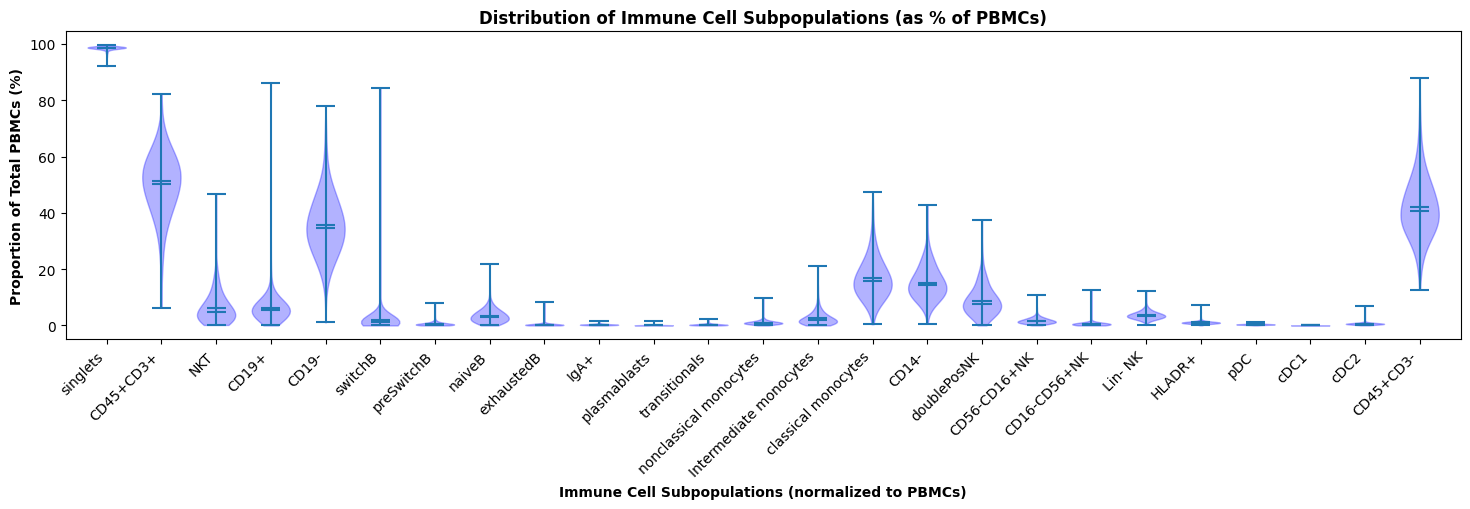

In [7]:
# plot for B panel
df = B_panel_df
plot_path = "/home/wenxiaren/Data_Analysis_and_Visualization/Plots/"
plot_name = "B_panel_phenotypes_distriution.png"
excluded_names = ["sampleName","PBMC","date","Unnamed: 57","Others_from_CD19neg","Others_from_CD14neg","CD45pos"]
output_path = plot_phenotypes_distri(df,excluded_names,plot_name,plot_path)


## Calculate the phenotypes

In [8]:
# calculate the total  NK, Monocytes
B_panel_df["NK"]  = B_panel_df["CD16negCD56posNK"]+B_panel_df["doublePosNK"]+B_panel_df["CD56negCD16posNK"]
B_panel_df["Monocytes"] = B_panel_df["classical_monocytes"] + B_panel_df["Intermediate_monocytes"] + B_panel_df["nonclassical_monocytes"]
B_panel_df["PBMC of total"]  = B_panel_df["PBMC/total"]
B_panel_df.columns
# calculate phenotype
B_phenotype_df = pd.read_excel(B_panel_phenotypes)
# loop over the phenotype definition table
for _, row in B_phenotype_df.iterrows():
    pheno_name = row["Phenotype"]          # column name to create
    target = row["Target"]                 # target population 
    parent = row["Parent"]                 # Parent population 
    
    if target in B_panel_df.columns and parent in B_panel_df.columns:
        B_panel_df[pheno_name] = B_panel_df[target] / B_panel_df[parent]
    else:
        print(f"Skipping {pheno_name}, missing target/parent")

Skipping PBMC of total, missing target/parent


In [9]:
# extract the sampling date 
B_panel_df["Sampling Date"] = B_panel_df["sampleName"].str.extract(r"(\d{4}-\d{2}-\d{2})")
# extract the sample ID matching with the one in the age and sex table
B_panel_df["tem Sample ID"] = B_panel_df["sampleName"].str.split("/").str[-1]
B_panel_df["Sample ID"] = B_panel_df["tem Sample ID"].str.split(" ",n=1).str[1]
# reformatting the data
B_panel_df["Sample ID"] = B_panel_df["Sample ID"].str.replace(r"A[\s-]?Detect", "Adetect", regex=True)
# there is one case where there is no space between Adetect and the letter coming after
# Replace "ADetect" (any case variation) with "Adetect " (with a space after)
B_panel_df["Sample ID"] = (
    B_panel_df["Sample ID"] # ensure a trailing space
    .str.replace(r"Adetect(?! )", "Adetect ", regex=True)  # fix cases with no space
)
# drop "tem Sample ID"
B_panel_df = B_panel_df.drop("tem Sample ID",axis=1)
B_panel_df["Date-ID"] = B_panel_df["Sampling Date"].astype(str)+"+"+B_panel_df["Sample ID"].astype(str)
# based on sample ID mapping the age and sex from age_sex_df into B_panel_df, if there is no infor, set as "NaN"
# some samples are missing info, so there are less samples in the age_sex_df than B_panel_df, 
B_panel_df = B_panel_df.merge(age_sex_df,on = "Sample ID",how="left")

print(B_panel_df.columns.tolist())
# status is the combination of cognitive status and Aβ status
B_panel_df["Status"] = np.where(
    B_panel_df["Group"].notna() & B_panel_df["Aβ"].notna(),
    B_panel_df["Group"].astype(str) + "-" + B_panel_df["Aβ"].astype(str),
    np.nan
)


['sampleName', 'PBMC', 'PBMC/total', 'singlets', 'singlets/PBMC', 'CD45pos', 'CD45pos/singlets', 'CD45posCD3pos', 'CD45posCD3pos/singlets', 'NKT', 'NKT/CD45posCD3pos', 'CD19pos', 'CD19pos/CD45pos', 'CD19neg', 'CD19neg/CD45pos', 'switchB', 'switchB/CD19pos', 'preSwitchB', 'preSwitchB/CD19pos', 'naiveB', 'naiveB/CD19pos', 'exhaustedB', 'exhaustedB/CD19pos', 'IgApos', 'IgApos/switchB', 'plasmablasts', 'plasmablasts/switchB', 'transitionals', 'transitionals/naiveB', 'nonclassical_monocytes', 'nonclassical_monocytes/CD19neg', 'Intermediate_monocytes', 'Intermediate_monocytes/CD19neg', 'classical_monocytes', 'classical_monocytes/CD19neg', 'CD14neg', 'CD14neg/CD19neg', 'Others_from_CD19neg', 'Others_from_CD19neg/CD19neg', 'doublePosNK', 'doublePosNK/CD14neg', 'CD56negCD16posNK', 'CD56negCD16posNK/CD14neg', 'CD16negCD56posNK', 'CD16negCD56posNK/CD14neg', 'doubleNegNK', 'doubleNegNK/CD14neg', 'Others_from_CD14neg', 'Others_from_CD14neg/CD14neg', 'HLADRpos', 'HLADRpos/doubleNegNK', 'pDC', 'pDC/d

In [10]:
B_panel_df.to_csv("New_Data/combined_cinical_data_and_before_normalization_B_panel.csv") 

## Normalization of Phenotypes

In [11]:
# Define normalization function
def normalization(data, phenotype_name):
    # Convert column to numpy array
    frequency = data[phenotype_name].to_numpy()
    frequency = pd.to_numeric(data[phenotype_name], errors="coerce").to_numpy()
    # Exclude NaN values
    valid = ~np.isnan(frequency)
    m = np.sum(valid)
    # Compute ranks
    # ‘average’: The average of the ranks that would have been assigned to all the tied values is assigned to each value.
    ranks = rankdata(frequency[valid], method="average")
    # Rankit formula: convert ranks to probabilities
    p = (ranks - 0.5) / m
    # Apply inverse normal CDF
    z = norm.ppf(p)
    # Insert transformed values back into full array
    frequency_transformed = frequency.copy()
    frequency_transformed[valid] = z
    return frequency_transformed

data = B_panel_df.copy()
# set some value as na
non_valid_sample = [ "9266-2","12988-1","12989-1","12990-1","12991-1","12992-1","12995-1","Adetect O036"]
# phenotype for bad non_valid_sample
related_phenotype_B = ['Classical Monocytes of Monocytes',
 'intermediate Monocytes of Monocytes',
 'non-classical Monocytes of Monocytes',
 'early NK of NK',
 'effector NK of NK',
 'terminal NK of NK',
 'cDC1 of DC',
 'cDC2 of DC',
 'pDC of DC']
# Convert non_valid_sample to a set 
non_valid_sample_set = set(non_valid_sample)
# Mask rows where "Sample ID" is one of the bad samples
mask = data["Sample ID"].isin(non_valid_sample_set)
mask
# Replace all values in the related_phenotype columns with empty string ("") for those rows
data.loc[mask, related_phenotype_B] = ""
print(f"Updated {mask.sum()} rows for {len(related_phenotype_B)} phenotype columns.")

# normalize the data
for _, row in B_phenotype_df.iterrows():
    pheno_name = row["Phenotype"]  # get the phenotype column name
    data[pheno_name + "_normalized"] = normalization(data, pheno_name)

# --- Select metadata columns to keep ---
meta_cols =  ["Sample ID","Sampling Date","Sex", "Age","Diagnosis","Group","Aβ","Status"]   
# Combine meta_cols with transformed phenotype columns
normalized_data = data[meta_cols + [col for col in data.columns if col.endswith("_normalized")]]
normalized_data.columns = [col.replace("_normalized", "") if col.endswith("_normalized") else col for col in normalized_data.columns]
normalized_data.columns = [col.replace(" ", "_") for col in normalized_data.columns]
normalized_data


Updated 8 rows for 9 phenotype columns.


/tmp/ipykernel_2797029/3836873274.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[mask, related_phenotype_B] = ""
/tmp/ipykernel_2797029/3836873274.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[mask, related_phenotype_B] = ""
/tmp/ipykernel_2797029/3836873274.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[mask, related_phenotype_B] = ""
/tmp/ipykernel_2797029/3836873274.py:40: FutureWarning: Setting an item of incompatible 

Sample_ID Sampling_Date     Sex   Age     Diagnosis Group        Aβ  \
0         10204-1    2023-04-24    Male 64.00  Dementia_VaD    CI       NaN   
1          9720-2    2024-10-07  Female 58.80       MCI_NOS    CI  Abnormal   
2      8789-3 FDI    2024-10-07    Male 72.08  Dementia_NOS    CI  Abnormal   
3          6950-4    2024-04-08  Female 60.74       MCI_NOS    CI       NaN   
4          7765-3    2023-04-24  Female 82.00       Control    CU       NaN   
..            ...           ...     ...   ...           ...   ...       ...   
663       12951-1    2025-08-05    Male 75.88       Control    CU       NaN   
664  Adetect E058    2025-09-30     NaN   NaN           NaN   NaN       NaN   
665        8095-4    2025-09-30  Female 81.92       Control    CU       NaN   
666       12952-1    2025-08-05  Female 71.06       Control    CU    Normal   
667       12906-1    2025-07-07    Male 65.37           SCD    CU    Normal   

          Status  PBMC_of_total  CD45+CD3-_of_singlets  ...  NK_of_CD19-  \
0            NaN          -0.35                   0.72  ...        -0.03   
1    CI-Abnormal          -0.21                  -0.83  ...        -0.97   
2    CI-Abnormal           0.02                  -0.46  ...        -0.07   
3            NaN           0.58                  -0.40  ...         0.78   
4            NaN           0.05                   1.07  ...         1.46   
..           ...            ...                    ...  ...          ...   
663          NaN          -1.04                   1.12  ...         0.34   
664          NaN          -1.15                   0.76  ...        -0.54   
665          NaN          -0.52                  -0.11  ...         1.05   
666    CU-Normal          -0.05                   0.05  ...         0.68   
667    CU-Normal           0.23                  -0.39  ...         1.19   

     NK_of_singlets  early_NK_of_NK  effector_NK_of_NK  terminal_NK_of_NK  \
0              0.52           -0.64              -1.51               1.82   
1             -1.11            0.54              -1.08               1.08   
2             -0.09            0.39              -0.48               0.49   
3              0.01           -0.38               0.88              -0.72   
4              1.87           -1.31               0.32               0.05   
..              ...             ...                ...                ...   
663            1.02            0.01              -0.30               0.44   
664            0.01           -1.14              -1.80               1.99   
665            0.93           -0.46              -0.76               0.95   
666            0.72            0.70               1.09              -1.67   
667            0.91           -0.07               1.77              -1.87   

     Monocytes_of_CD19-  Monocytes_of_singlets  \
0                  0.23                   0.82   
1                  0.80                  -0.14   
2                  0.26                   0.08   
3                 -1.00                  -1.33   
4                 -1.33                   0.07   
..                  ...                    ...   
663               -0.12                   1.12   
664                1.00                   1.14   
665               -0.80                  -0.22   
666               -0.46                   0.01   
667               -1.92                  -1.35   

     Classical_Monocytes_of_Monocytes  intermediate_Monocytes_of_Monocytes  \
0                               -2.04                                 1.53   
1                                0.62                                -0.41   
2                                0.65                                -0.51   
3                               -0.50                                 0.51   
4                               -1.27                                 1.06   
..                                ...                                  ...   
663                              0.21                                -0.35

In [12]:
normalized_data.to_csv("New_Data/B_panel_normalized.csv", index=False)

# Batch effect

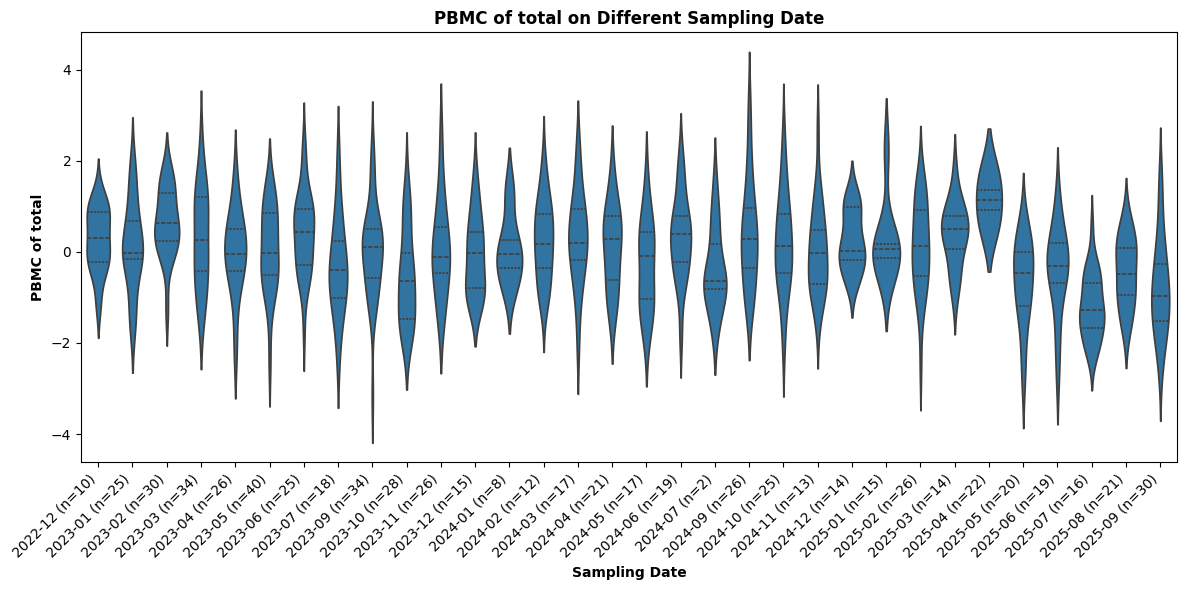

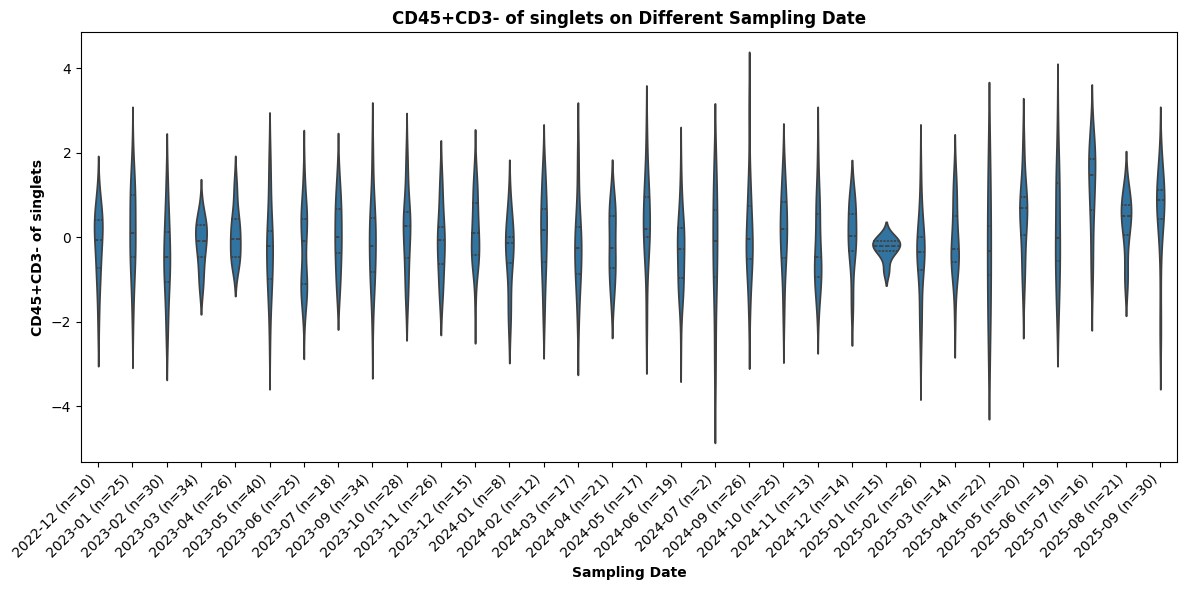

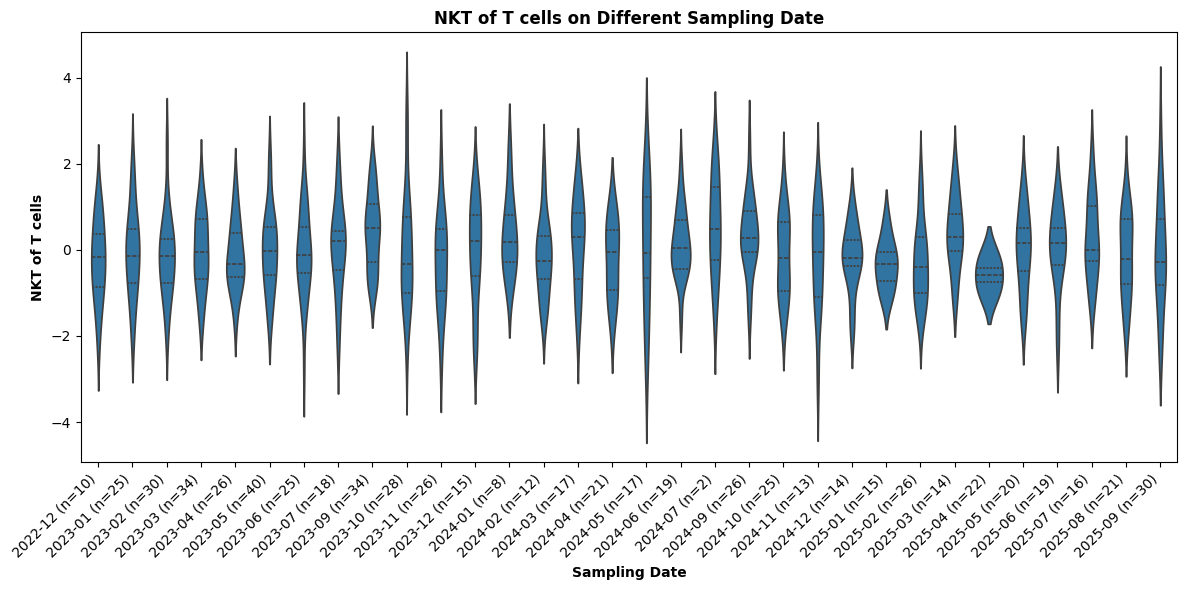

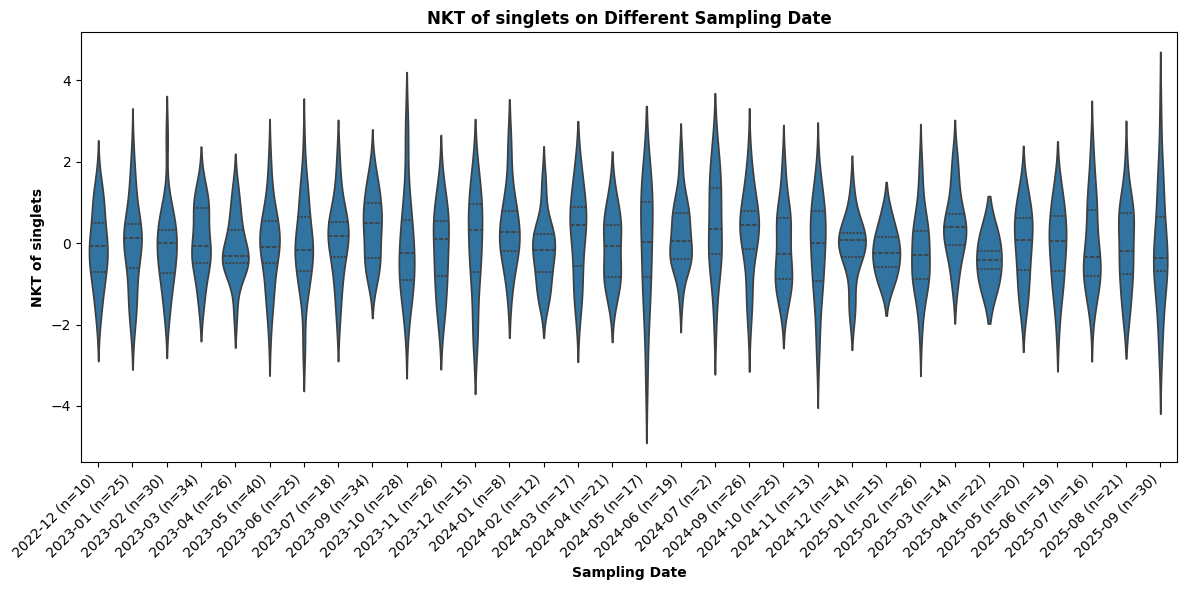

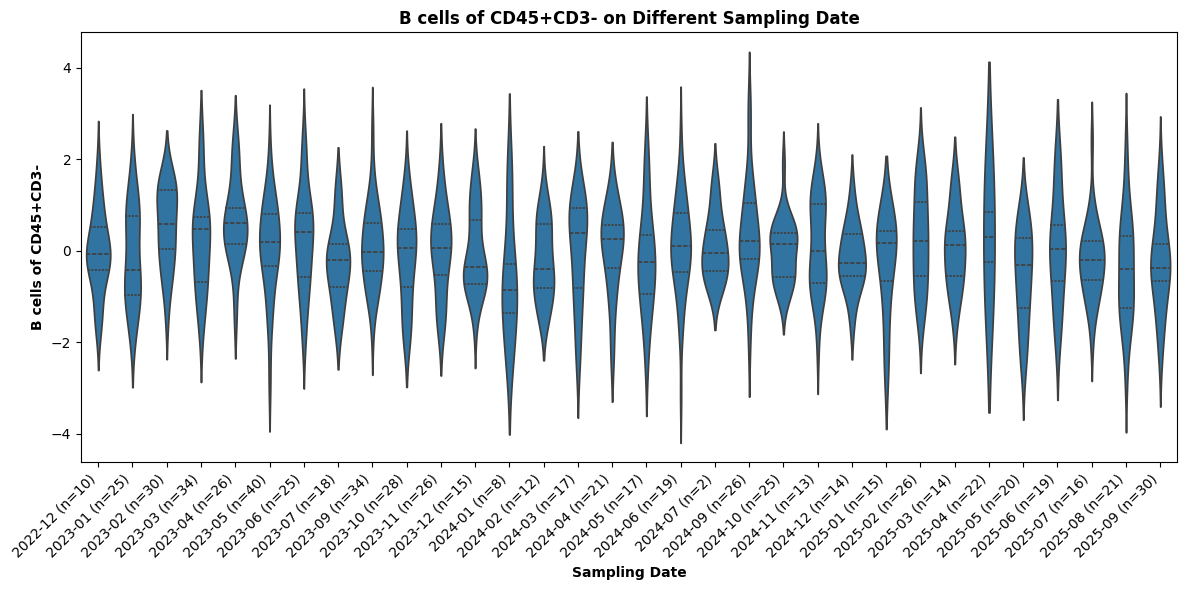

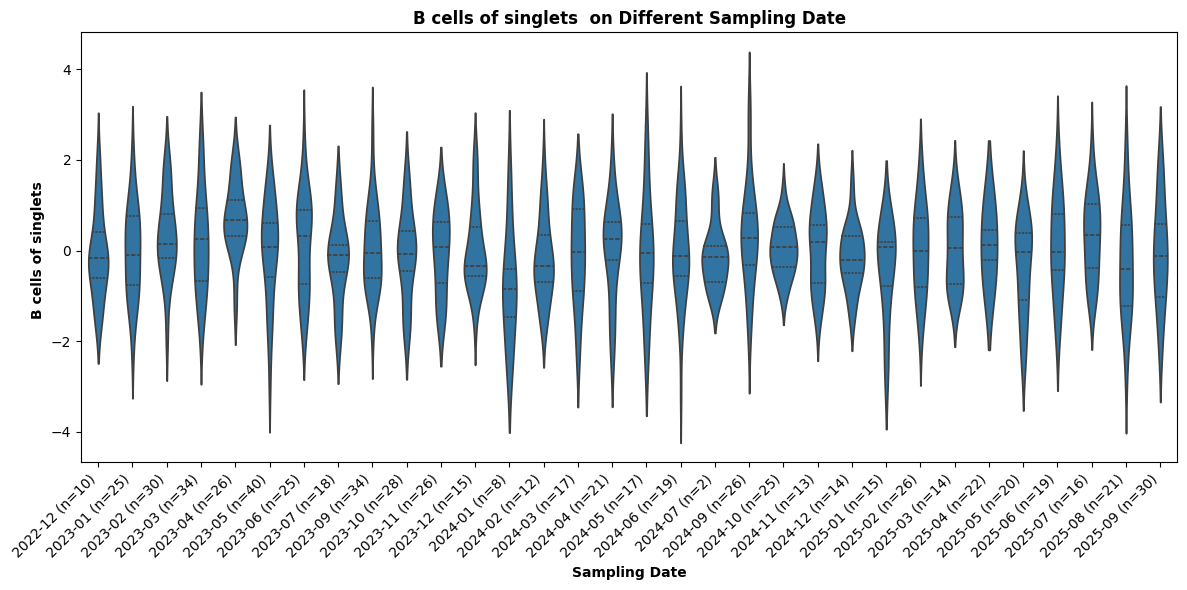

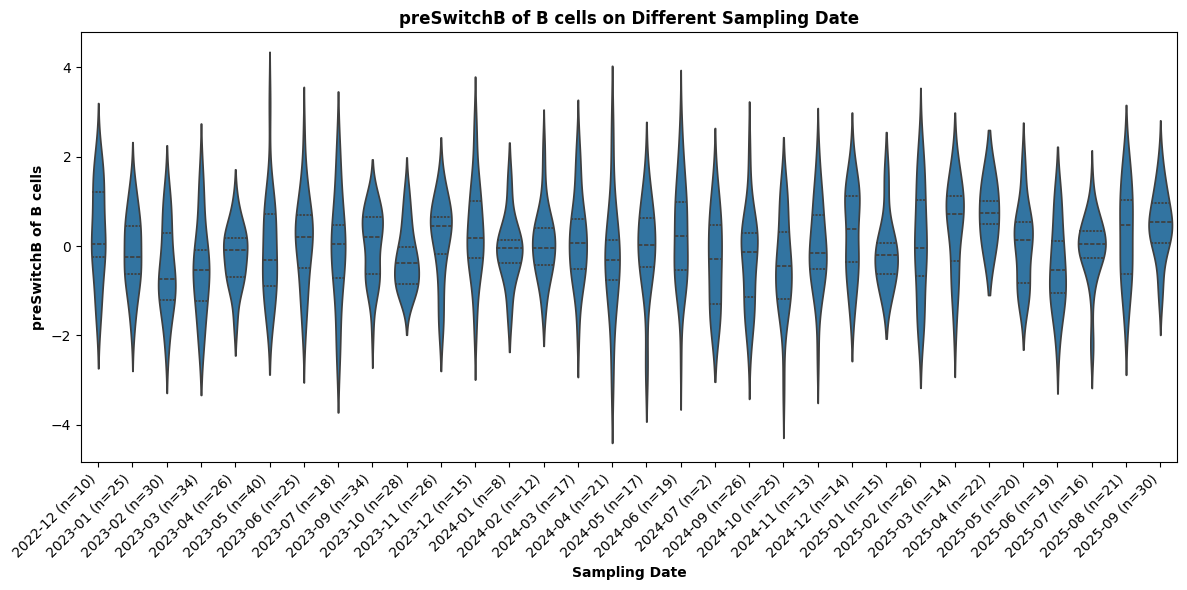

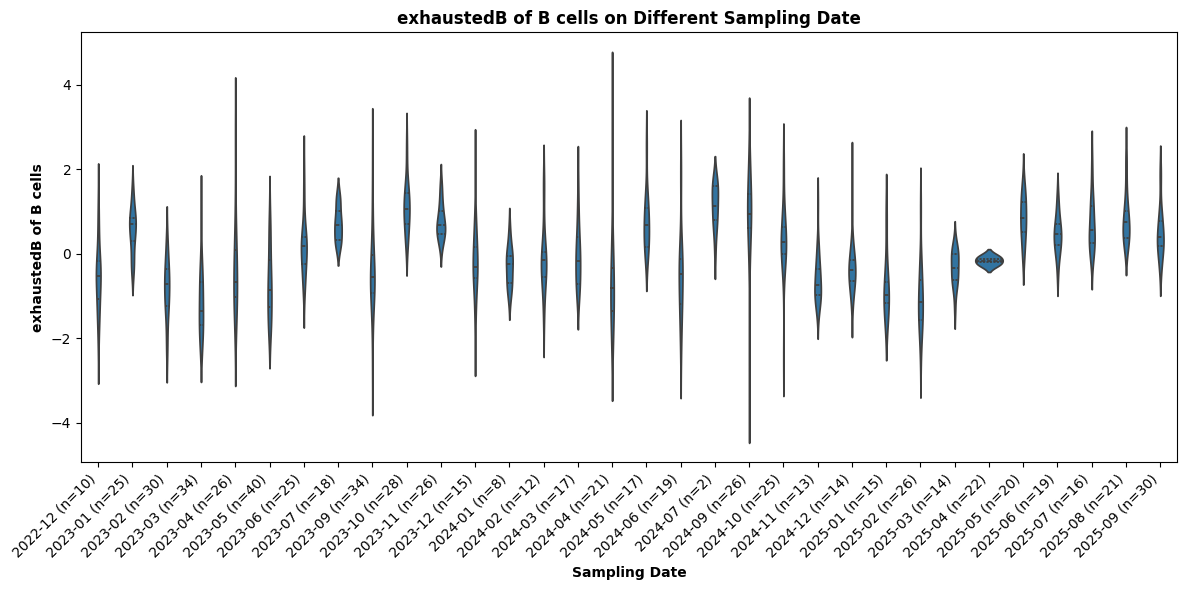

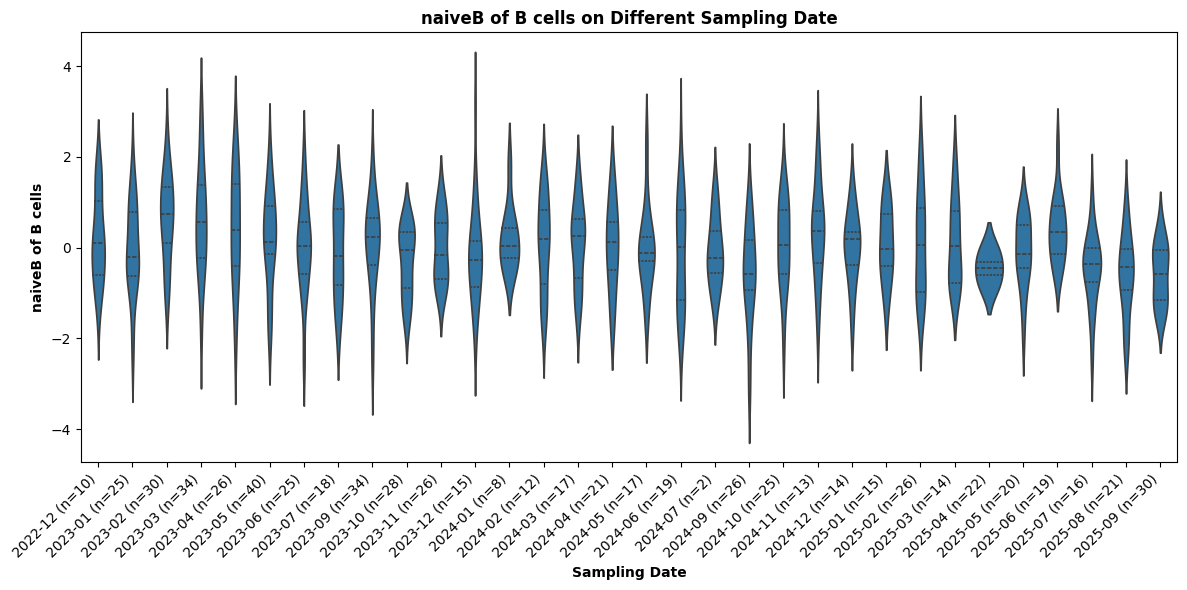

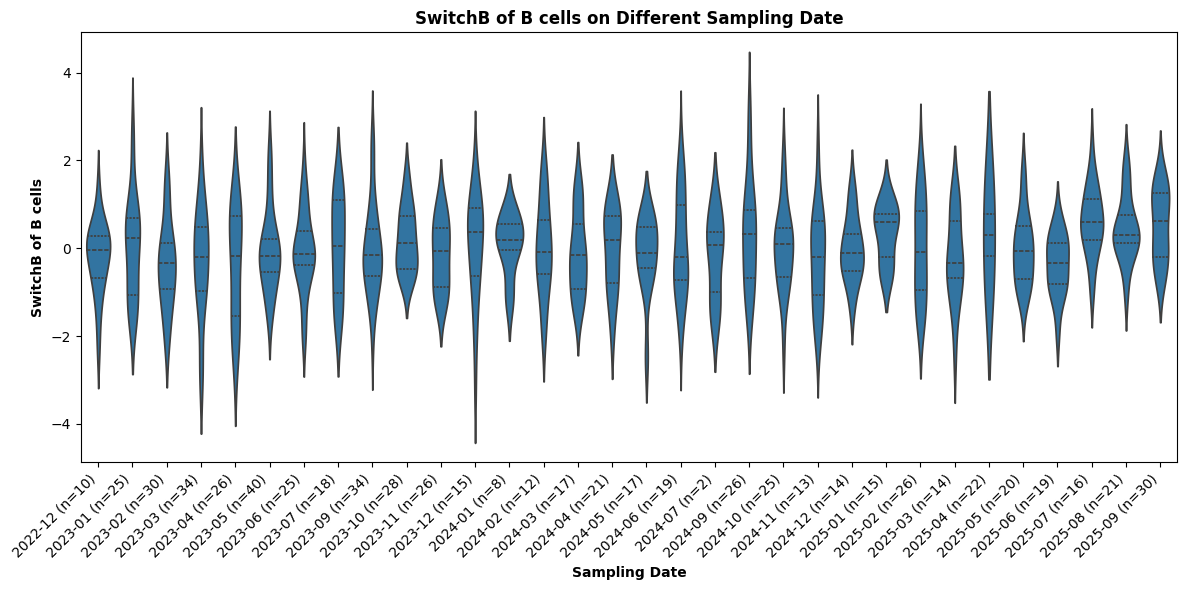

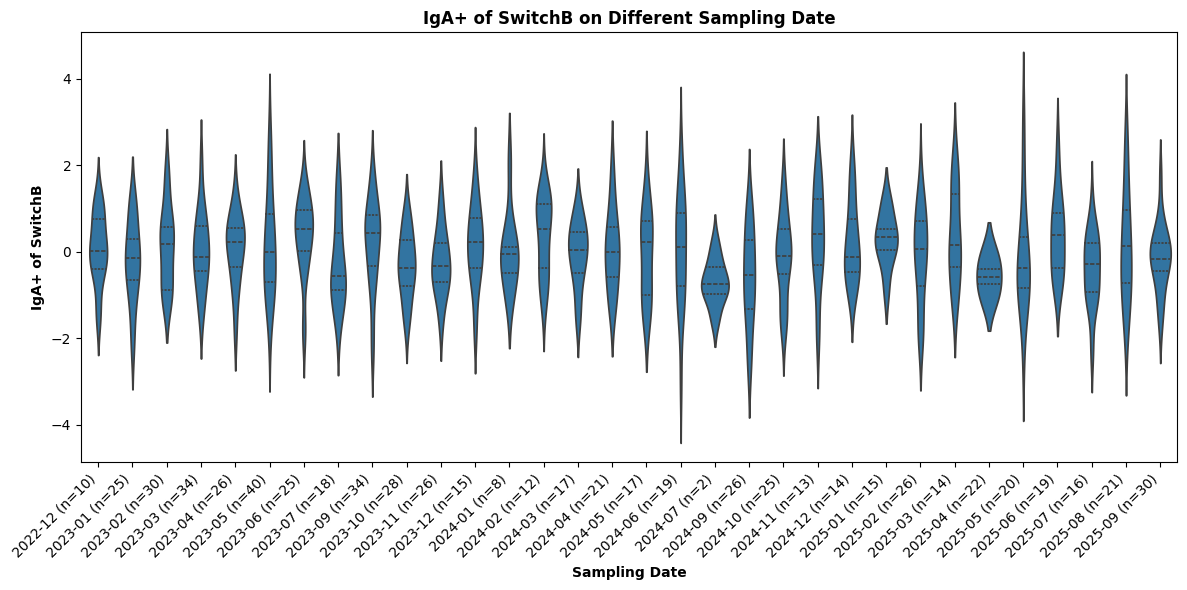

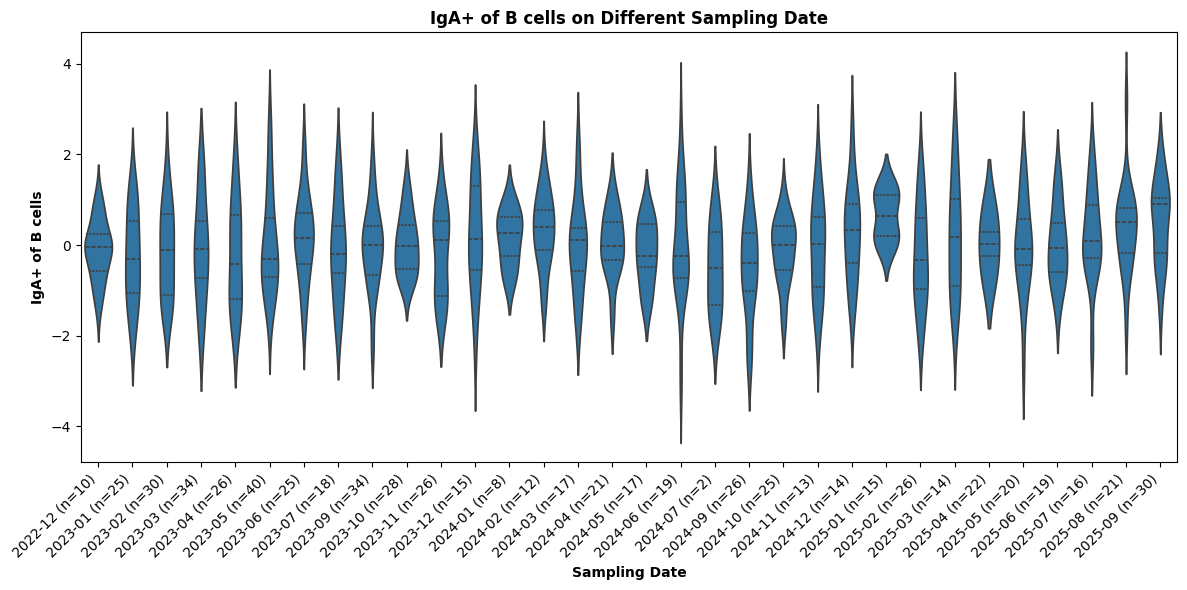

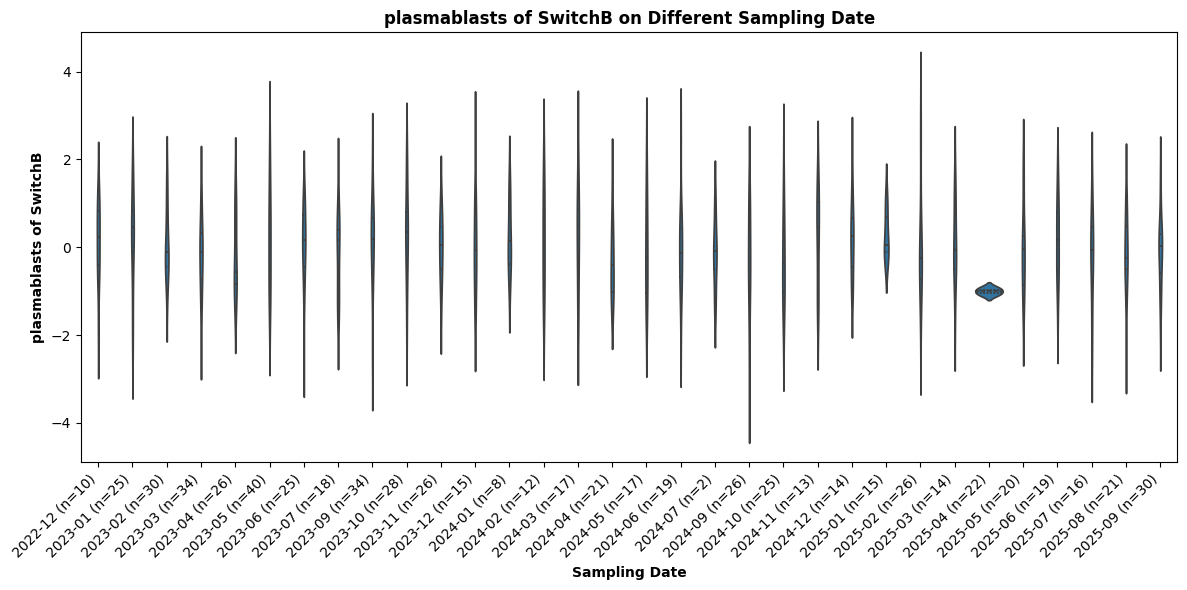

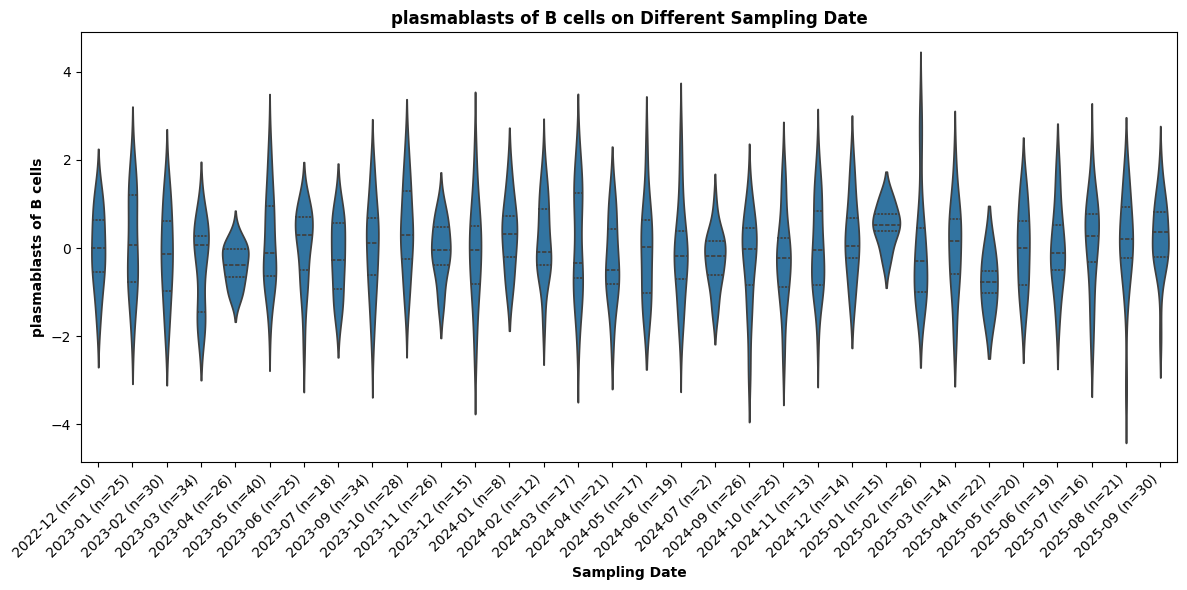

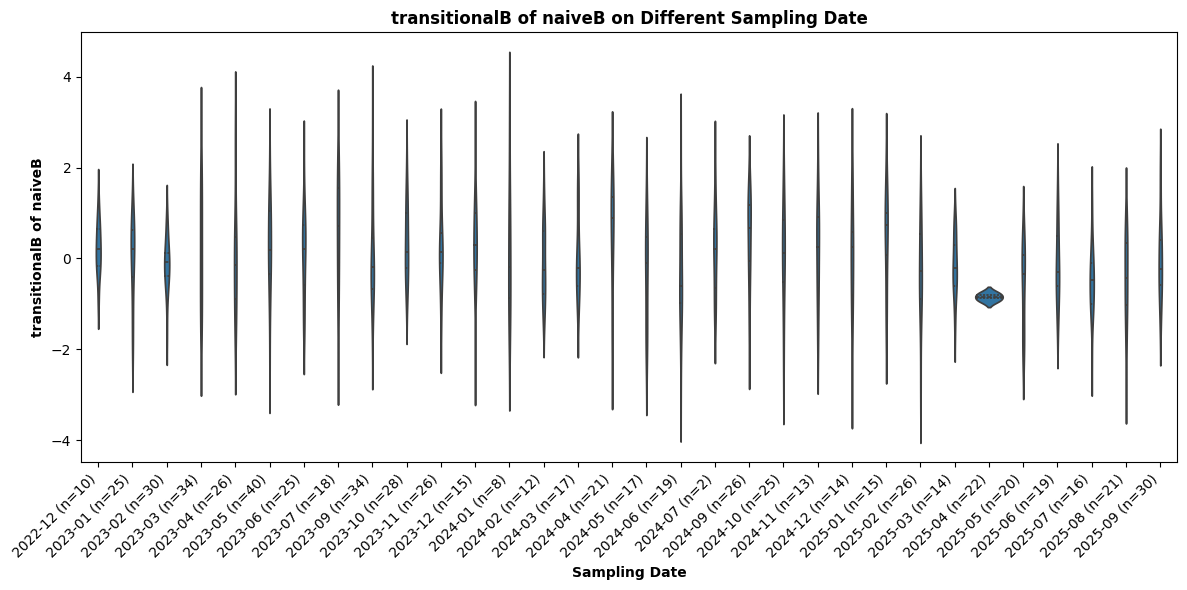

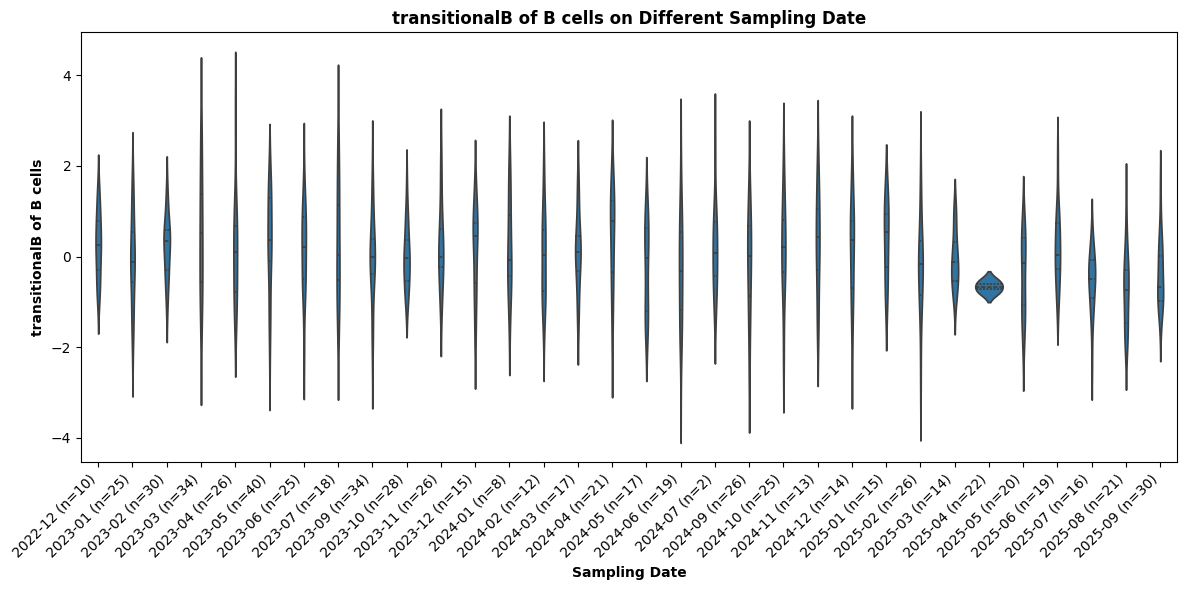

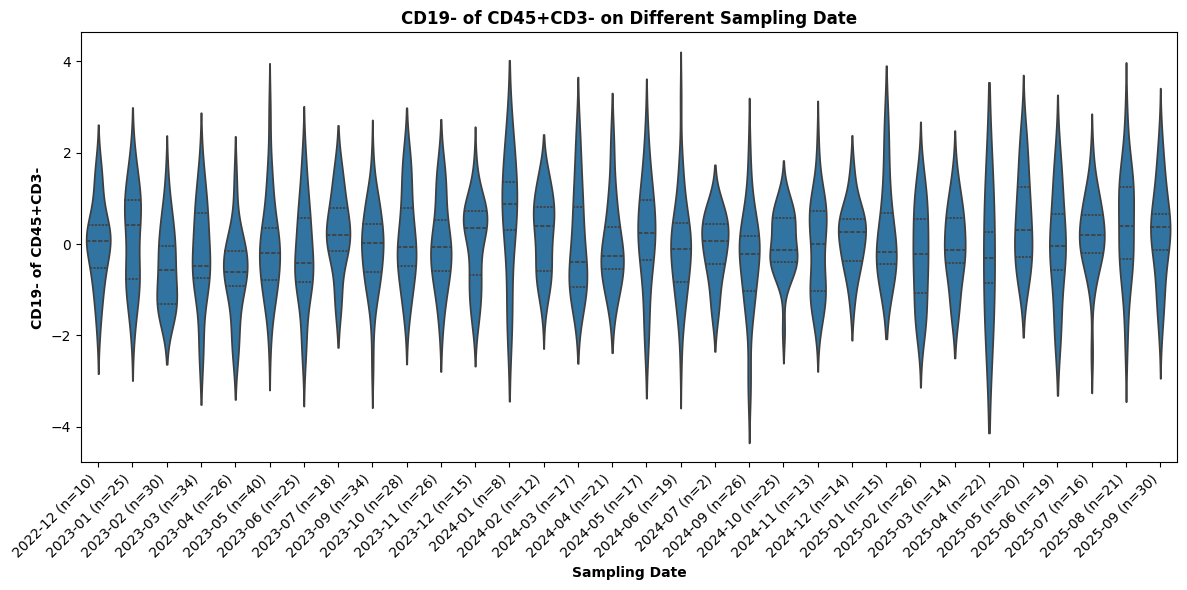

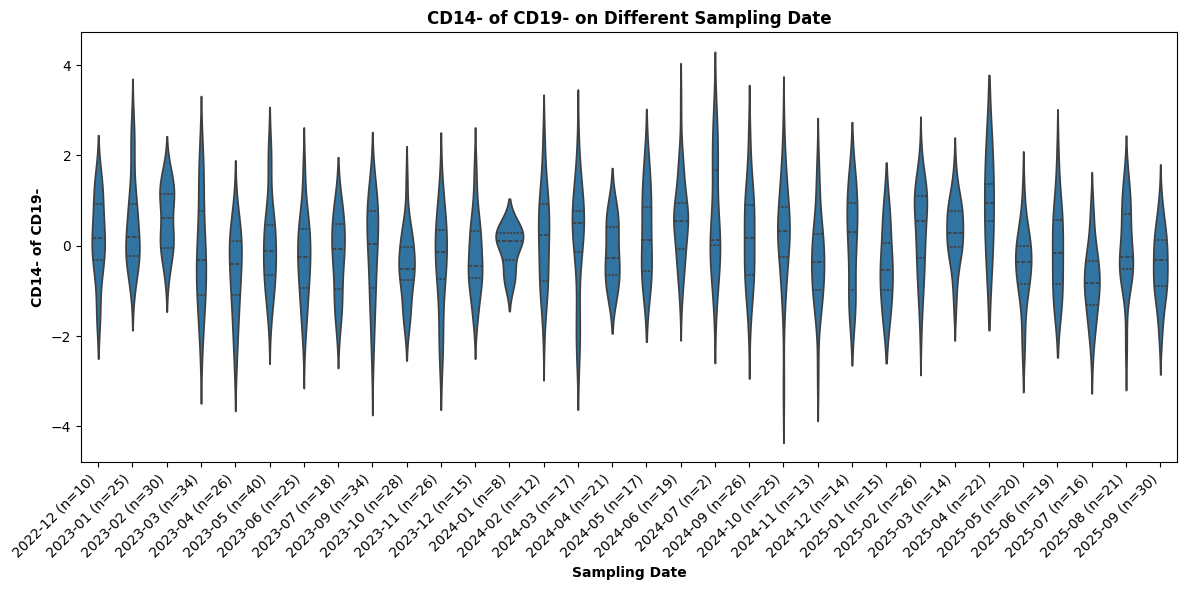

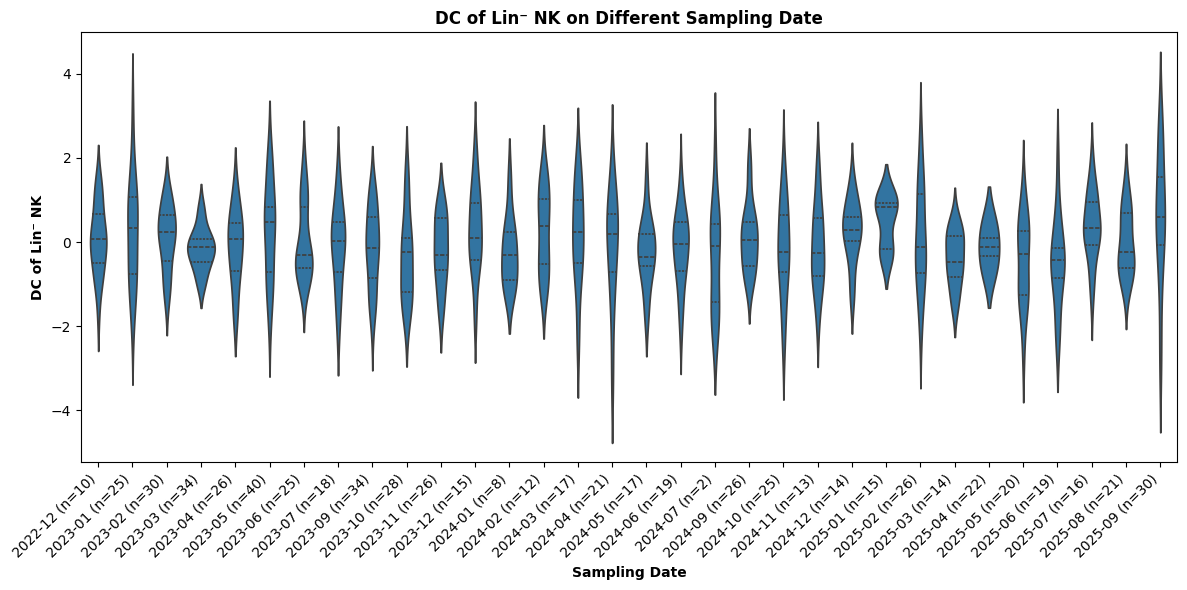

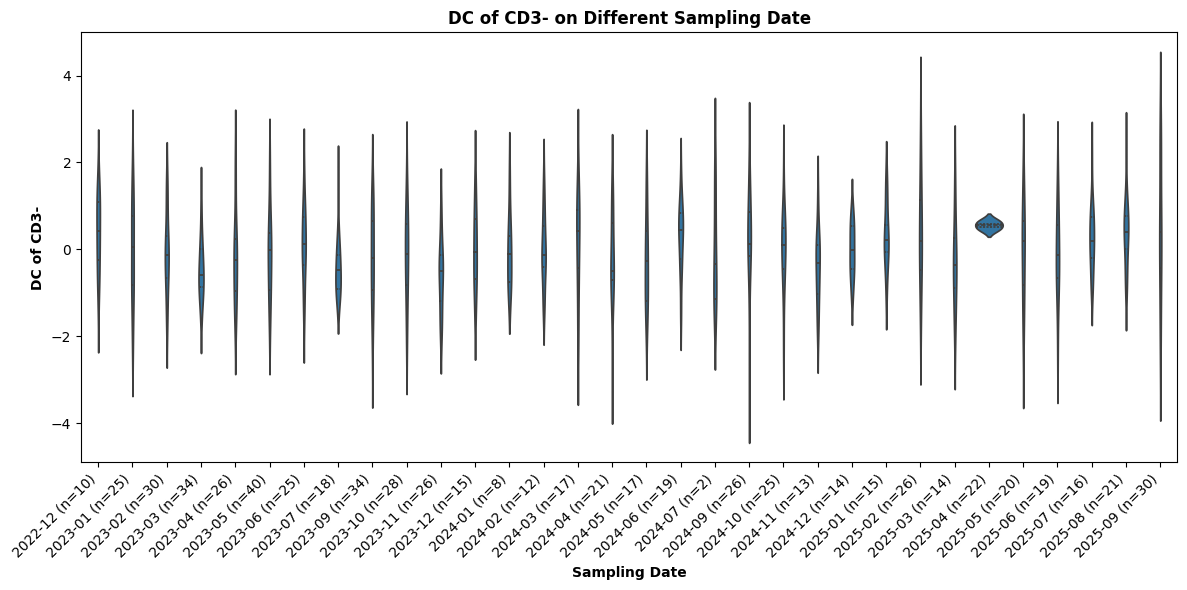

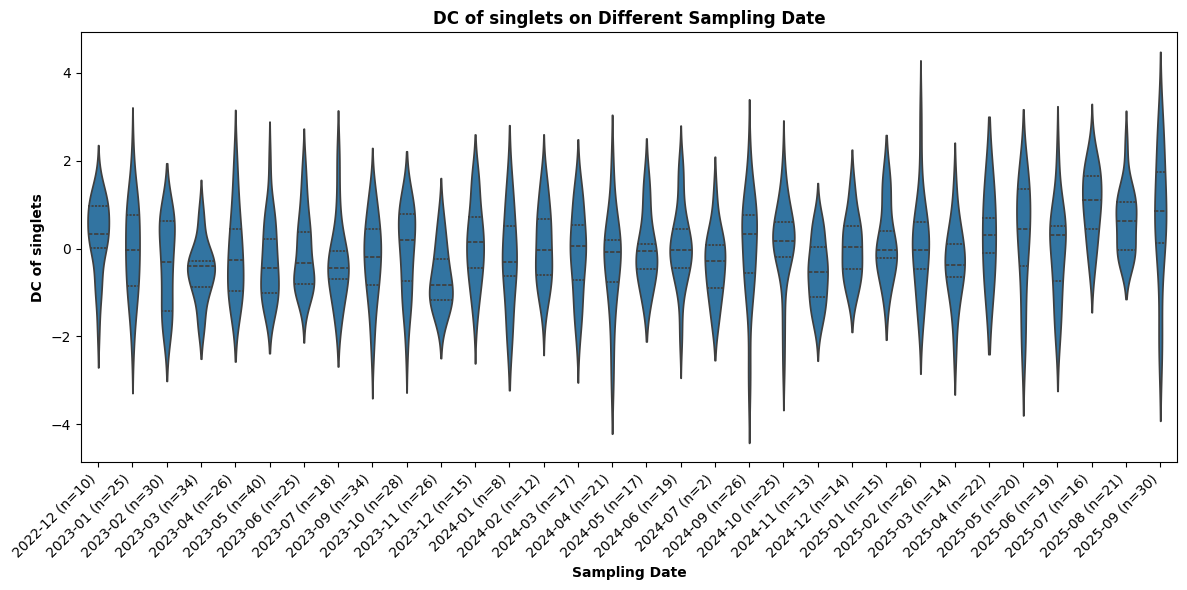

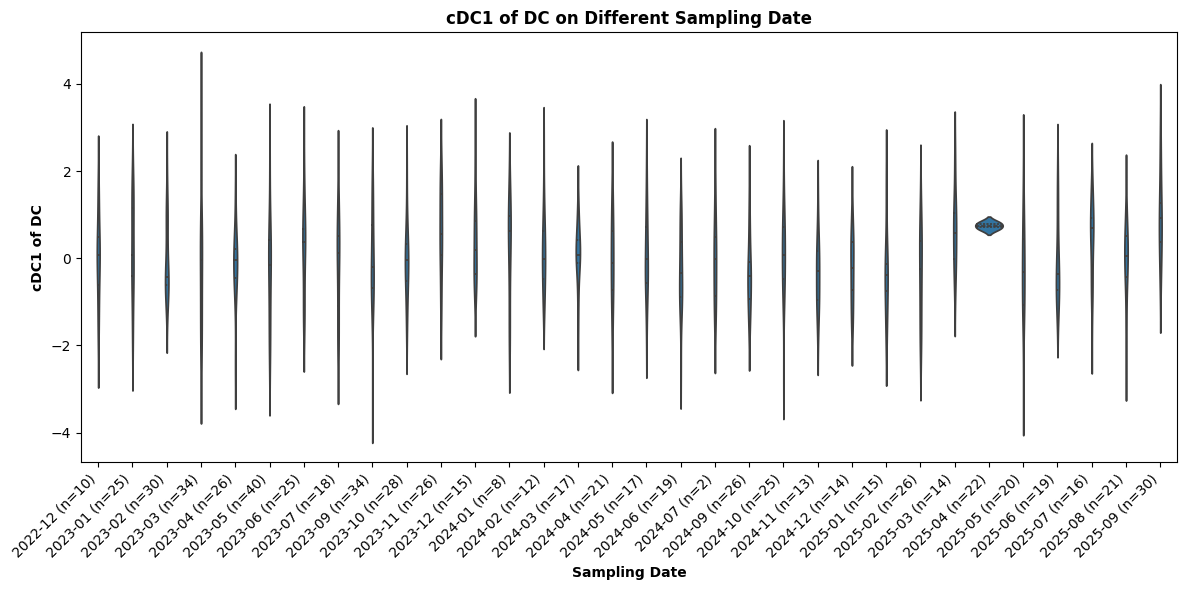

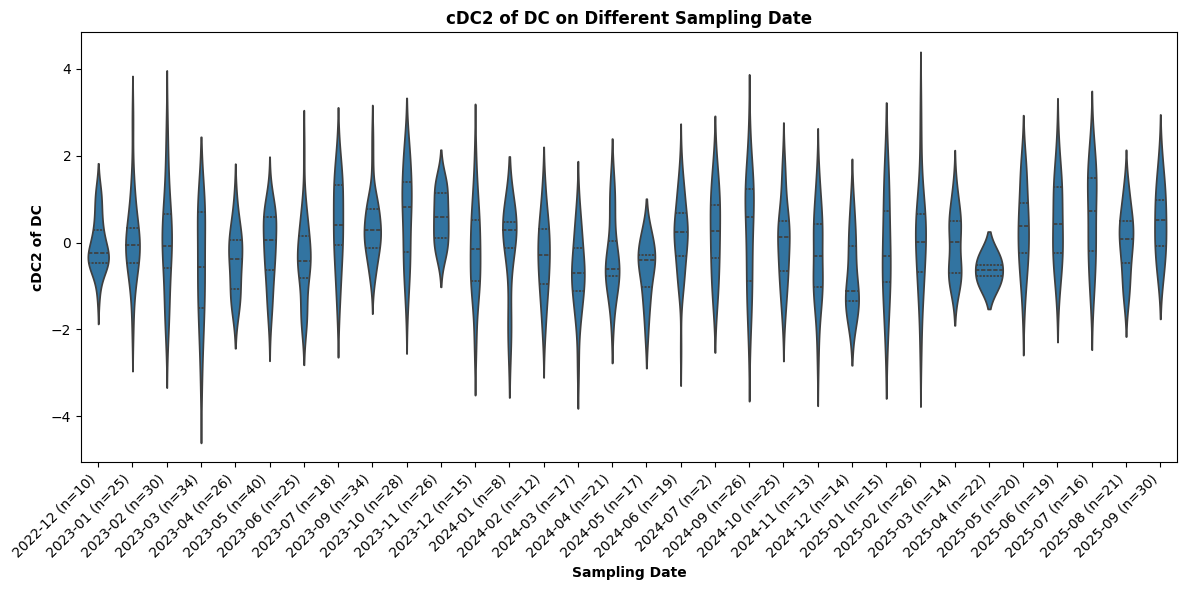

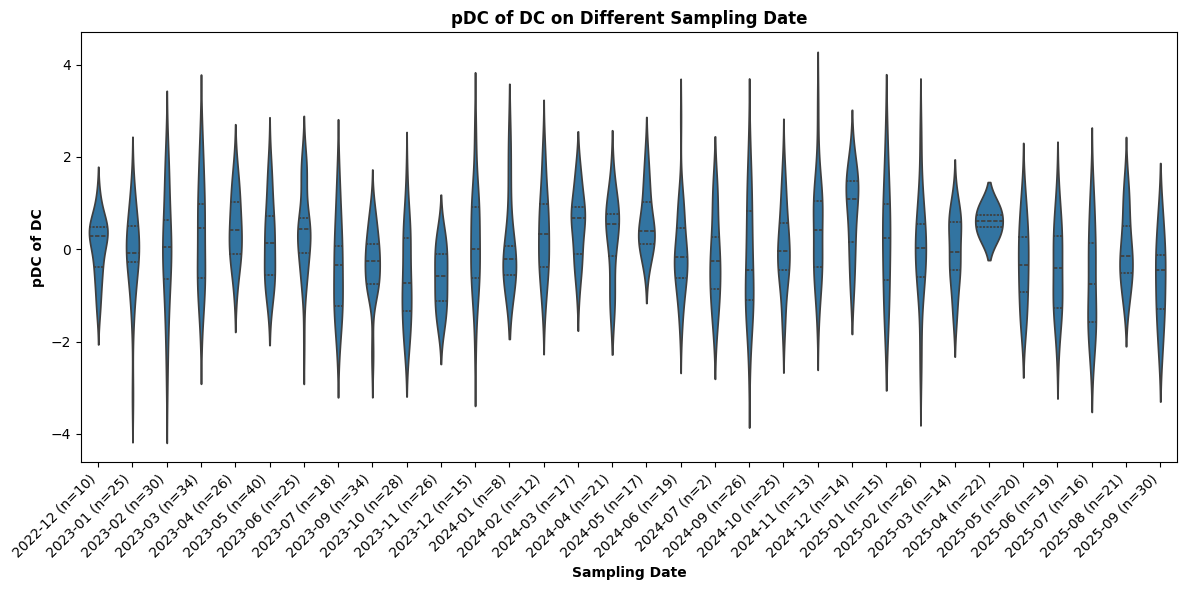

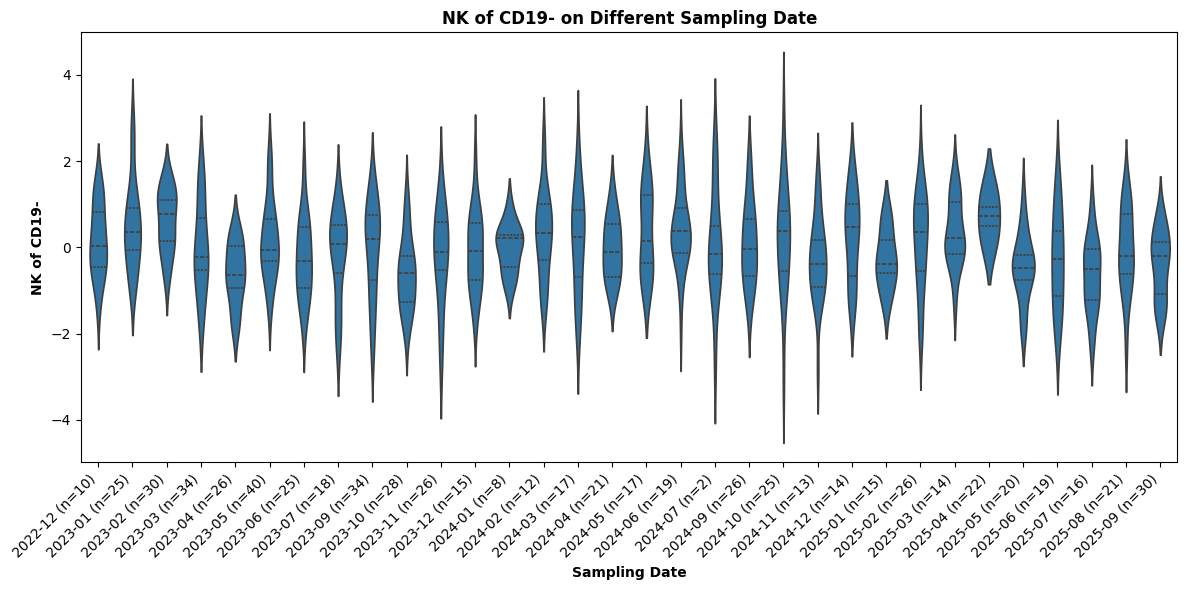

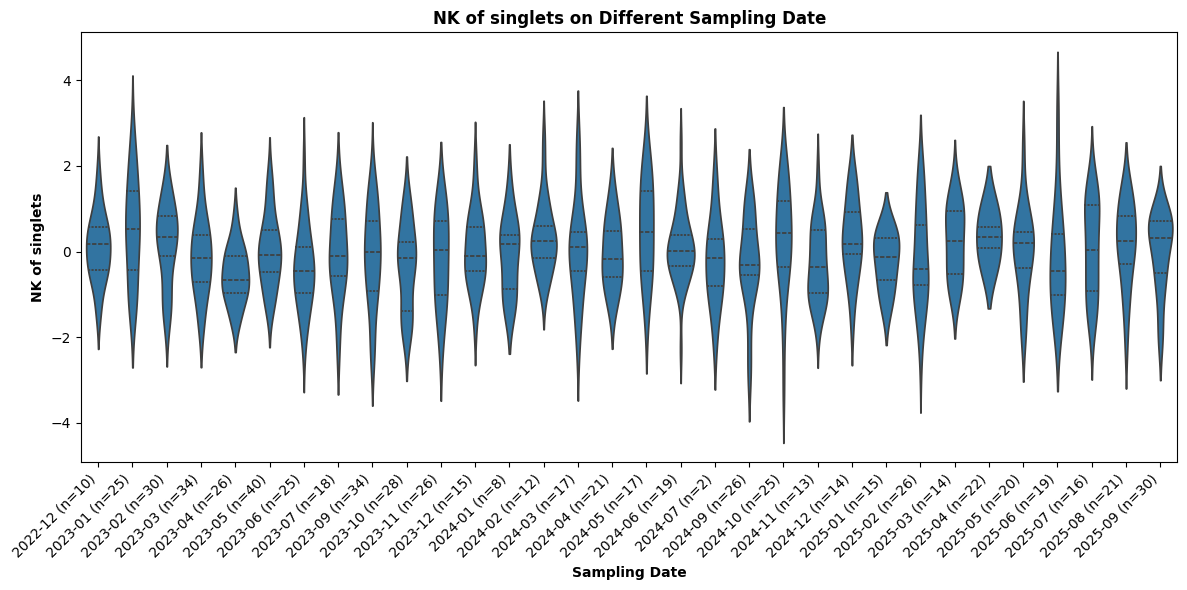

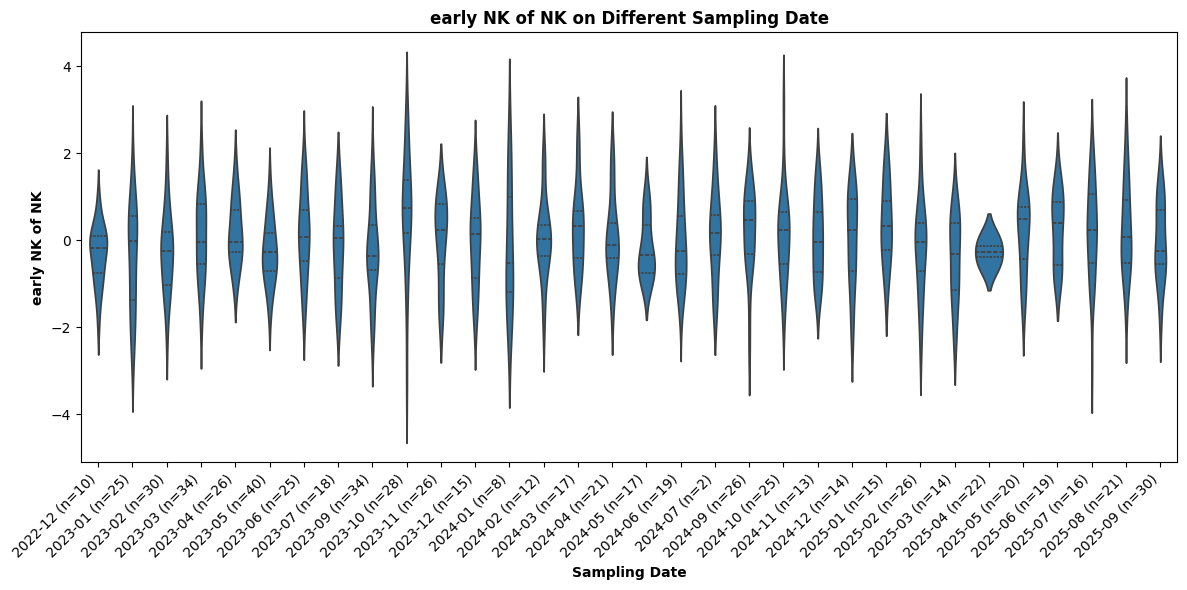

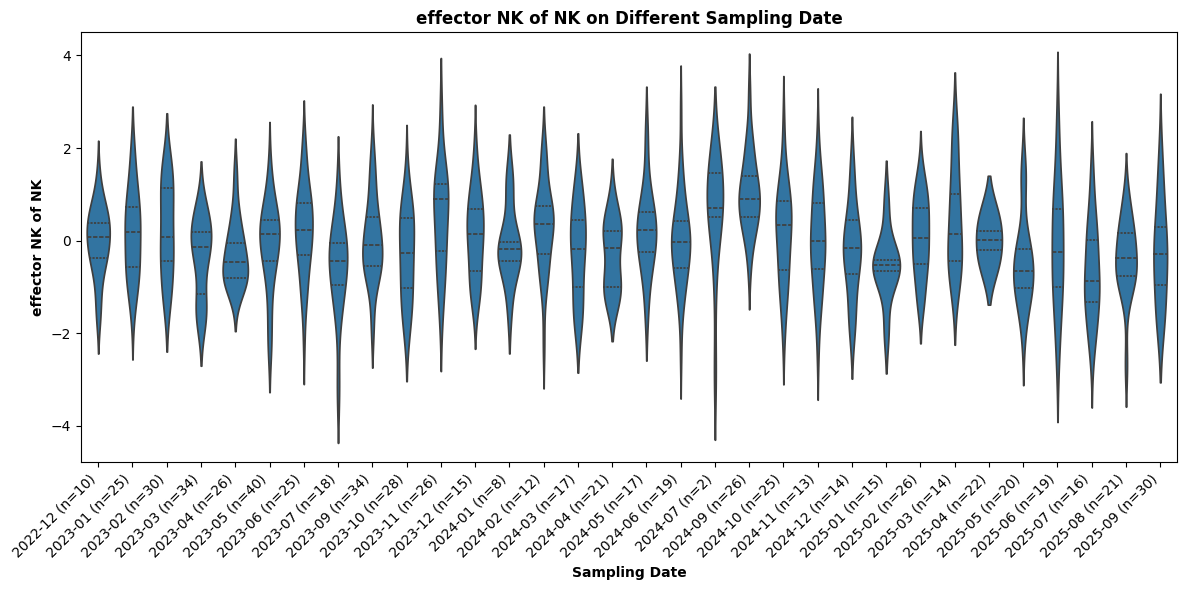

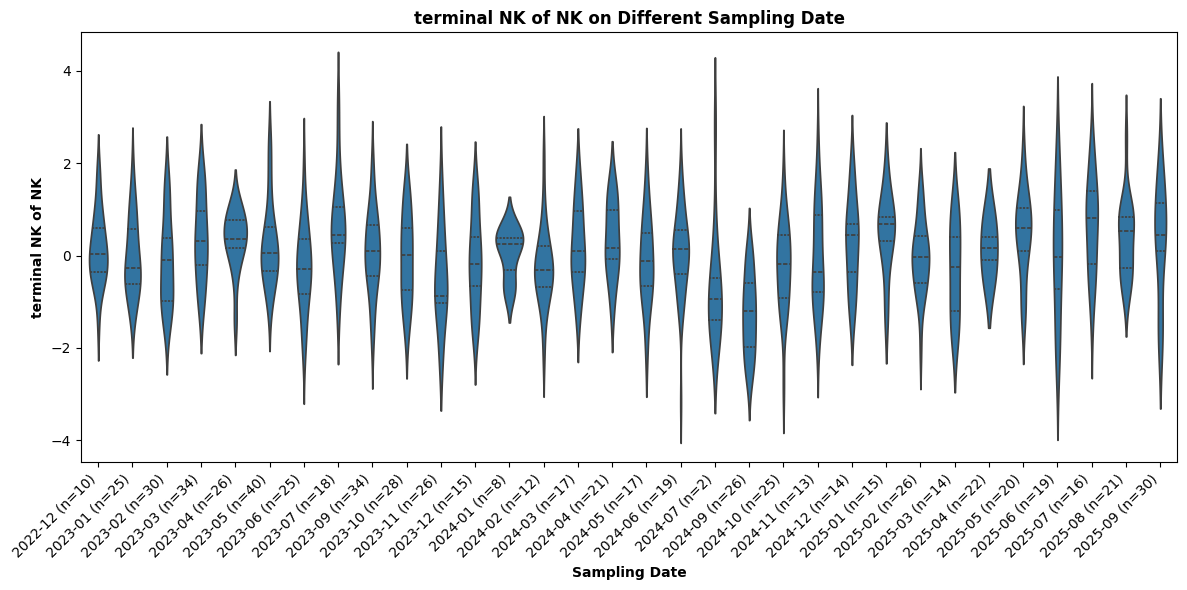

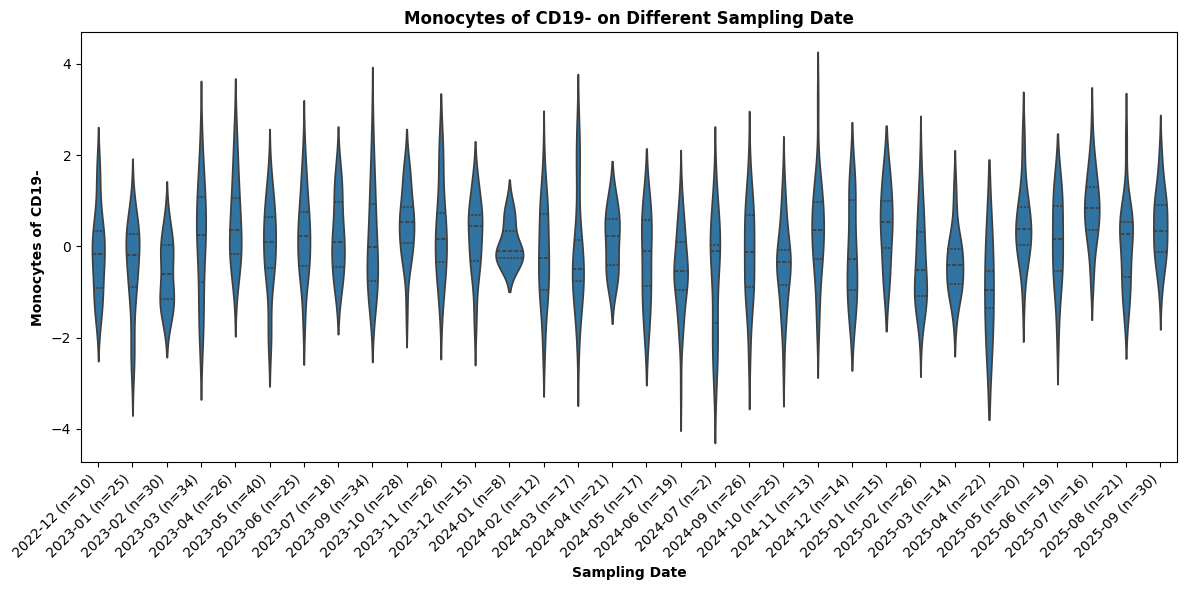

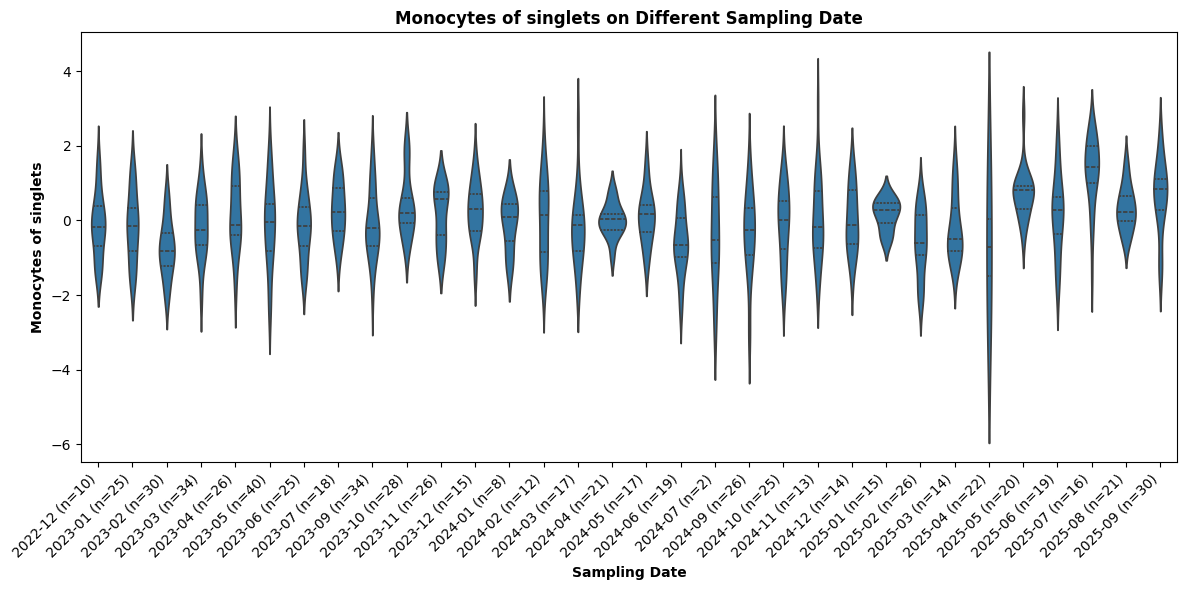

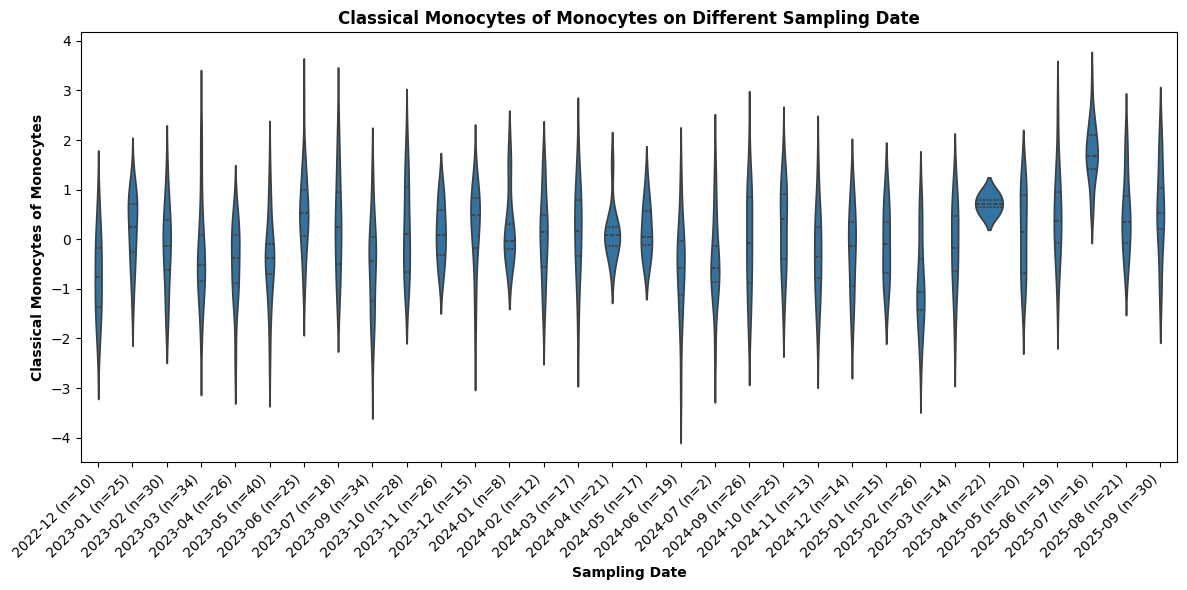

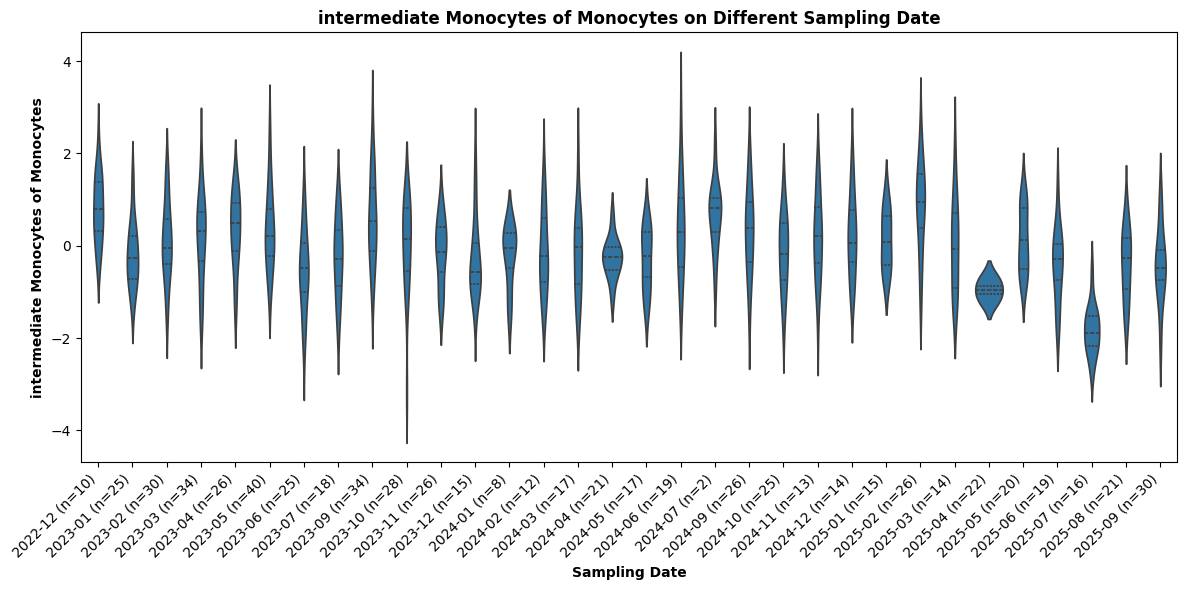

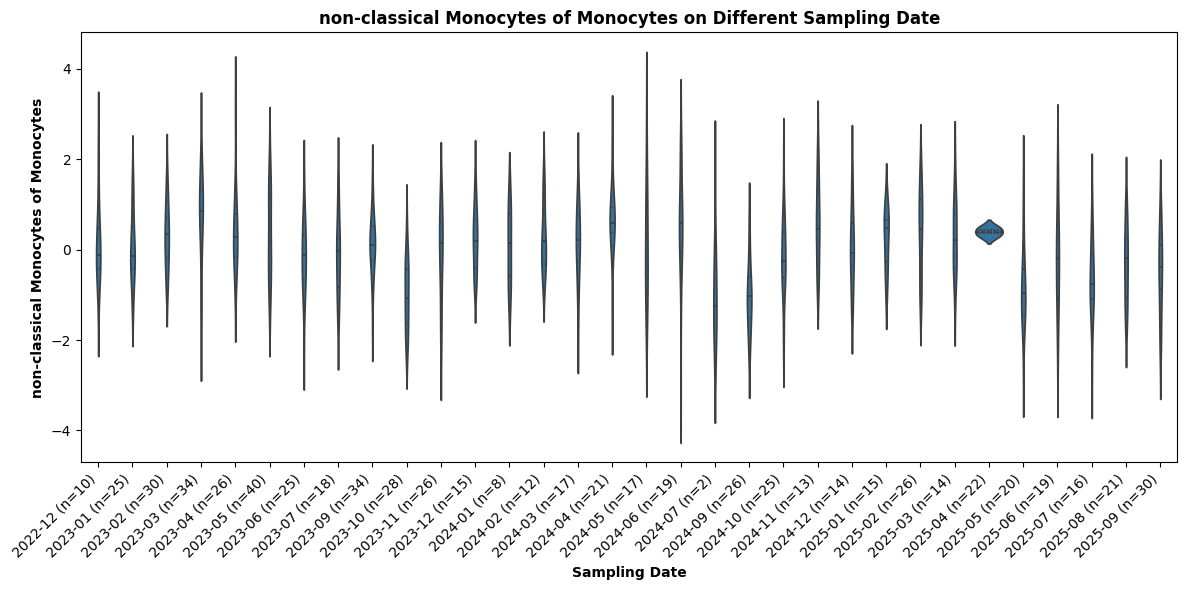

In [13]:
# plot the violin plot
def plot_batch_effect_violin(expected_population,n,current_dir,df):
    plt.figure(figsize=(12,6))
    # plot the scatter plot (all raw points per date)
    sns.violinplot(data=df, x="date", y=expected_population, inner="quartile")
    # sns.violinplot(data=df, x="date", y="PBMC/total", inner=None)  # inner=None = cleaner violin
    # Count samples per date
    counts = df["date"].value_counts().sort_index()
    # Update xtick labels with counts
    new_labels = [f"{date} (n={counts[date]})" for date in counts.index]
    title_name = expected_population.replace("_"," ")
    plt.xticks(range(len(counts)), new_labels, rotation=45,ha="right")
    plt.title("Percentage Distribution per Date")
    plt.xlabel("Sampling Date",fontweight='bold')
    plt.ylabel(title_name,fontweight='bold')
    plt.title(title_name+" on Different Sampling Date",fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(current_dir, str(n)+"_violin.png"))
    plt.show()
    plt.close()
   
# extract the percentage title from the df.column based on "/"
df = normalized_data.copy()
df["date"] = df["Sampling_Date"].apply(lambda x: re.search(r"\d{4}-\d{2}",x).group() if re.search(r"\d{4}-\d{2}",x) else None)
column_names = [col for col in df.columns if "of" in col.lower()]
n=1
current_dir = "/home/wenxiaren/Data_Analysis_and_Visualization/Plots/"
# call plot_batch_effect function
for column_name in column_names:
    plot_batch_effect_violin(column_name,n,current_dir,df)
    n+=1

In [14]:
# Extract Sample IDs with missing sex
missing_sex_ids = B_panel_df.loc[B_panel_df["Sex"].isna(), "Sample ID"]
# Or save to a CSV for record keeping
missing_sex_ids.to_excel("New_Data/missing_sex_ids_from_B_panel.xlsx", index=False)

In [15]:
# check if the tables are merged correctly 
print(B_panel_df["Sex"].value_counts())
# in the clinical data, the male is 163, female is 153, total 316 
# check the misising part
missing_age_sex_df = age_sex_df.merge(B_panel_df,on='Sample ID', how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
missing_age_sex_df["Sample ID"]
# there are three reason why they are missing: without blood sample, without fcs files, or with fcs file but less events numbers than the cellFilter value (100000), couldn't continue with the AliGate.

Sex
Male      296
Female    282
Name: count, dtype: int64


0            9924-1
1            8712-2
5            7444-3
13     Adetect E033
22           9967-1
           ...     
691            T201
692            V026
693            Y033
694            Y036
695            Y041
Name: Sample ID, Length: 118, dtype: object

In [16]:
missing_age_sex_df.to_excel("New_Data/B_panel_missing_age_sex.xlsx")  

# T-panel

In [17]:
# load the gating result from B panel
T_panel_df = pd.read_csv(T_panel_path, header=0,sep="\t",index_col=False)
T_panel_df.columns

Index(['sampleName', 'PBMC', 'PBMC/total', 'singlets', 'singlets/PBMC',
       'CD3pos', 'CD3pos/singlets', 'CD3neg', 'CD3neg/singlets',
       'CD3pos_CD39pos',
       ...
       'Th17/Th22_Th17', 'Th17_CD39pos', 'Th17_CD39pos/Th17', 'Th22_CD39pos',
       'Th22_CD39pos/Th22', 'Th17_HLADRpos', 'Th17_HLADRpos/Th17',
       'Th22_HLADRpos', 'Th22_HLADRpos/Th22', 'Unnamed: 199'],
      dtype='object', length=200)

# Plot the distribution of subpopulations normalized to PBMCs

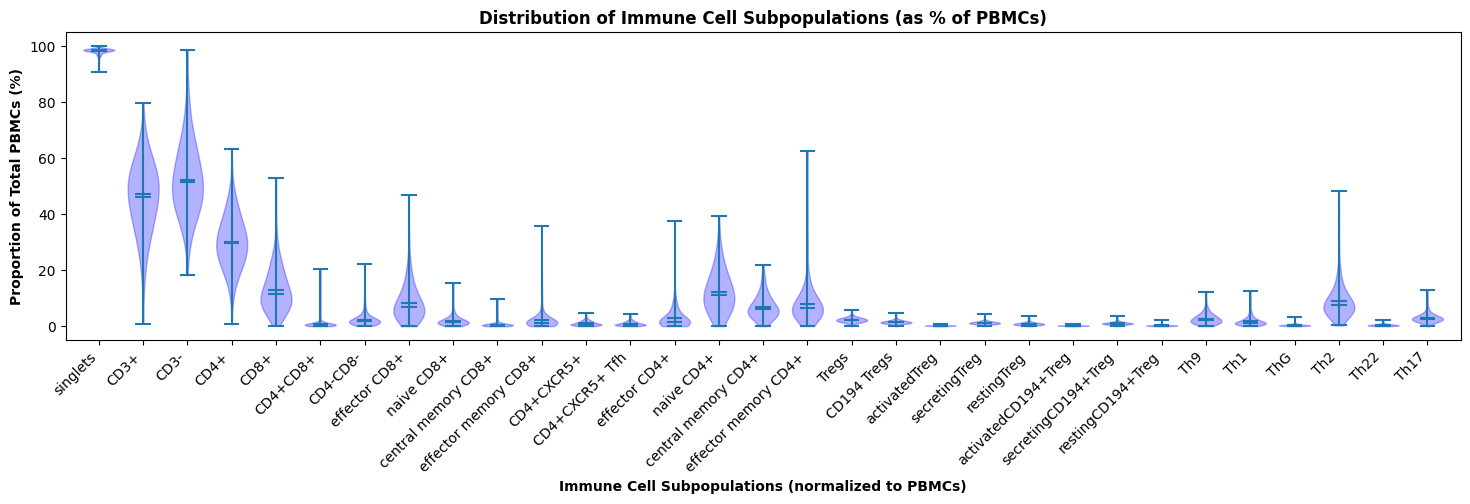

In [18]:
# plot for T panel
df = T_panel_df
excluded_names = ["sampleName", "PBMC", "date", "Unnamed: 199","non_naive_T","Th1_Th2_ThG","Th22_Th17"]
columns_names  = list(df.columns)
# also exclude the columns whose names have "CD39" or "HLADR"
for i in columns_names:
    if (("CD39" in i) or ("HLADR" in i)) and ("/" not in i):
        excluded_names.append(i)
excluded_names
# plot for T panel
plot_path = "/home/wenxiaren/Data_Analysis_and_Visualization/Plots/"
plot_name = "T_panel_phenotypes_distriution.png"
output_path = plot_phenotypes_distri(df,excluded_names,plot_name,plot_path)

In [19]:
cols_no_slash = [col for col in T_panel_df.columns if "/" not in col and not col.startswith("Unnamed")]
# Convert to DataFrame
df = pd.DataFrame(cols_no_slash, columns=["population"])
# Save to Excel
df.to_excel("population_index.xlsx", index=False)

# Calculate the Phenotypes

In [20]:
# calculate the percentage of expected phenotype in T panel
# add Non-naive helper
T_panel_df["Non-naive helper"] = T_panel_df["central_memory_CD4pos"] + T_panel_df["effector_memory_CD4pos"] + T_panel_df["effector_CD4pos"]
T_panel_df["Th1 of Th1-Th2-ThG"]  = T_panel_df["Th1/Th1_Th2_ThG"]
T_panel_df["Th2 of Th1-Th2-ThG"]  = T_panel_df["Th2/Th1_Th2_ThG"] 
T_panel_df["ThG of Th1-Th2-ThG"]  = T_panel_df["ThG/Th1_Th2_ThG"]
phenotype_df = pd.read_excel(T_panel_phenotypes)

# Loop over the phenotype definition table
for _, row in phenotype_df.iterrows():
    pheno_name = row["Phenotype"]          # column name to create
    target = row["Target"]                 # numerator
    parent = row["Parent"]                 # denominator
    
    if target in T_panel_df.columns and parent in T_panel_df.columns:
        T_panel_df[pheno_name] = T_panel_df[target] / T_panel_df[parent]
    else:
        print(f"Skipping {pheno_name}, missing target/parent")


Skipping Th1 of Th1-Th2-ThG, missing target/parent
Skipping Th2 of Th1-Th2-ThG, missing target/parent
Skipping ThG of Th1-Th2-ThG, missing target/parent


In [21]:
# extract the sampling date  
T_panel_df["CD4/CD8 ratio"] = T_panel_df["Helper of singlets"]/T_panel_df["Cytotoxic of singlets"]
T_panel_df["Sampling Date"] = T_panel_df["sampleName"].str.extract(r"(\d{4}-\d{2}-\d{2})")
# extract the sample ID matching with the one in the age and sex table
T_panel_df["tem Sample ID"] = T_panel_df["sampleName"].str.split("/").str[-1]
T_panel_df["Sample ID"] = T_panel_df["tem Sample ID"].str.split(" ",n=1).str[1]
T_panel_df["Sample ID"] = T_panel_df["Sample ID"].str.replace(r"A[\s-]?Detect", "Adetect", regex=True)
# reformatting the data
# T_panel_df["Sample ID"] = T_panel_df["Sample ID"].str.replace("A Detect","Adetect")
# T_panel_df["Sample ID"] = T_panel_df["Sample ID"].str.replace("ADetect","Adetect")
# T_panel_df["Sample ID"] = T_panel_df["Sample ID"].str.replace("A-Detect","Adetect")
# there is one case where there is no space between Adetect and the letter coming after
# Replace "ADetect" (any case variation) with "Adetect " (with a space after)
T_panel_df["Sample ID"] = (
    T_panel_df["Sample ID"] # ensure a trailing space
    .str.replace(r"Adetect(?! )", "Adetect ", regex=True)  # fix cases with no space
)
# drop "tem Sample ID"
T_panel_df = T_panel_df.drop("tem Sample ID",axis=1)
T_panel_df = T_panel_df.drop("Unnamed: 199",axis=1)
# based on sample ID mapping the age and sex from age_sex_df into B_panel_df, if there is no infor, set as "NaN"
# some samples are missing info, so there are less samples in the age_sex_df than B_panel_df, 
T_panel_df = T_panel_df.merge(age_sex_df,on = "Sample ID",how="left")
# B_panel_df.to_excel("output3.xlsx")
T_panel_df["Date-ID"] = T_panel_df["Sampling Date"].astype(str)+"+"+T_panel_df["Sample ID"].astype(str)


In [22]:
T_panel_df.to_csv("New_Data/combined_cinical_data_and_before_normalization_T_panel.csv") 

# Normalization of Phenotypes

In [23]:
data = T_panel_df.copy()
# set some value as na
# phenotype for bad samples
bad_sample = ["Adetect A039","Adetect B034","8824-2 FDI","8902-2 FDI","10043-1","10044-1","10045-1","10046-1","Adetect B029","8817-2","8843-2",
              "7550-3","10063-1","10064-1","10065-1","Adetect B035",
              "Adetect C040","7357-3","7759-3","8954-2","10079-1","8441-3","8510-3 FDI","7273-4","Adetect Y016","7272-4","Adetect A052","Adetect A056"]
related_phenotype_T1 =[
 'CM-Cytotoxic of Cytotoxic',
 'CM Cytotoxic HLADR+ of CM Cytotoxic',
 'EM-Cytotoxic of Cytotoxic',
 'EM-Cytotoxic-HLADR+ of EM-Cytotoxic',
 'Naive-Cytotoxic of Cytotoxic',
 'Naive-Cytotoxic-HLADR+ of Naive-Cytotoxic',
 'TEMRA-Cytotoxic of Cytotoxic',
 'TEMRA-Cytotoxic-HLADR+ of TEMRA-Cytotoxic']
# Convert bad_sample to a set 
bad_sample_set = set(bad_sample)
# Mask rows where "Sample ID" is one of the bad samples
mask = data["Sample ID"].isin(bad_sample_set)
# Replace all values in the related_phenotype columns with empty string ("") for those rows
data.loc[mask, related_phenotype_T1] = ""
print(f"Updated {mask.sum()} rows for {len(related_phenotype_T1)} phenotype columns.")

# set some value as na
bad_sample_2 = [ "9266-2","12988-1","12989-1","12990-1","12991-1","12992-1","12995-1","Adetect O036"]
# phenotype for bad samples_1
related_phenotype_T2=['Activated Tregs of Tregs',
 'Activated Tregs CD39+ of Activated Tregs',
 'Resting Tregs of Tregs',
 'Resting Tregs CD39+ of Resting Tregs',
 'Secreting Tregs of Tregs',
 'Secreting Tregs CD39+ of Secreting Tregs',
 'Tregs HLADR+ of Tregs',
 'Tregs CD194+ of Tregs',
 'Tregs CD194+ HLADR+ of Tregs CD194+',
 'Activated CD194+ Tregs of CD194+ Tregs',
 'Resting CD194+ Tregs of CD194+ Tregs',
 'Secreting CD194+ Tregs of CD194+ Tregs',
 'Activated CD194+ Tregs CD39 of Activated CD194+ Tregs',
 'Resting CD194+ Tregs CD39 of Resting CD194+ Tregs',
 'Secreting CD194+ Tregs CD39 of Secreting CD194+ Tregs',
 'Th1 HLADR+ of Th1',
 'Th2 HLADR+ of Th2',
 'ThG HLADR+ of ThG',
 'Th9 HLADR+ of Th9',
 'Th22 Th17 of Non naive Helper',
 'Th17 HLADR+ of Th17',
 'Th22 HLADR+ of Th22']
# Convert bad_sample_2 to a set for faster lookup
bad_sample_2_set = set(bad_sample_2)
# Mask rows where "Sample ID" is one of the bad samples
mask = data["Sample ID"].isin(bad_sample_2_set)
# Replace all values in the related_phenotype columns with empty string ("") for those rows
data.loc[mask, related_phenotype_T2] = ""
print(f"Updated {mask.sum()} rows for {len(related_phenotype_T2)} phenotype columns.")

# Normalizing the data
for _, row in phenotype_df.iterrows():
    pheno_name = row["Phenotype"]  
    data[pheno_name + "_normalized"] = normalization(data, pheno_name)
# --- Select metadata columns to keep ---
meta_cols =  ["Sample ID","Sampling Date","Sex", "Age","Diagnosis","Group","Aβ"] 
# Combine metadata with transformed phenotype columns
normalized_data_T = data[meta_cols + [col for col in data.columns if col.endswith("_normalized")]]
normalized_data_T.columns = [col.replace("_normalized", "") if col.endswith("_normalized") else col for col in normalized_data_T.columns]
normalized_data_T.columns = [col.replace(" ", "_") for col in normalized_data_T.columns]
normalized_data_T.to_csv("New_Data/T_panel_normalized.csv", index=False)
normalized_data_T

Updated 28 rows for 8 phenotype columns.
Updated 8 rows for 22 phenotype columns.


/tmp/ipykernel_2797029/2179979369.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[mask, related_phenotype_T1] = ""
/tmp/ipykernel_2797029/2179979369.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[mask, related_phenotype_T2] = ""
/tmp/ipykernel_2797029/2179979369.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[mask, related_phenotype_T2] = ""
/tmp/ipykernel_2797029/2179979369.py:54: FutureWarning: Setting an item of incompatib

Sample_ID Sampling_Date     Sex   Age Diagnosis Group        Aβ  \
0    Adetect Y025    2024-11-05  Female 79.01   SCD_NOS    CU  Abnormal   
1    Adetect T068    2023-07-04  Female 77.76    MCI_AD    CI  Abnormal   
2         10864-1    2023-07-04  Female 76.38   Control    CU    Normal   
3         10862-1    2023-07-04  Female 78.46   Control    CU    Normal   
4         10842-1    2023-06-26  Female 62.21   Control    CU    Normal   
..            ...           ...     ...   ...       ...   ...       ...   
664        7927-4    2025-05-19  Female 63.36   Control    CU       NaN   
665   10463-2 FDI    2025-05-19     NaN   NaN       NaN   NaN       NaN   
666       12944-1    2025-07-28  Female 67.89   Control    CU       NaN   
667       12940-1    2025-07-14  Female 84.24   Control    CU  Abnormal   
668       12939-1    2025-07-14    Male 71.33   Control    CU  Abnormal   

     CD3-_of_singlets  T_cells_of_singlet  Helper_of_T_cells  ...  \
0                1.18               -1.18               0.89  ...   
1               -0.25                0.25              -1.35  ...   
2               -0.38                0.38              -0.12  ...   
3               -0.81                0.81              -0.47  ...   
4               -1.00                1.00              -0.98  ...   
..                ...                 ...                ...  ...   
664              0.48               -0.48              -0.38  ...   
665              0.35               -0.35               0.60  ...   
666              1.14               -1.14               1.62  ...   
667             -0.15                0.15               2.34  ...   
668             -0.57                0.57              -1.40  ...   

     Cytotoxic_HLADR+_of_Cytotoxic  CM_Cytotoxic_of_Cytotoxic  \
0                             0.57                      -0.23   
1                             0.65                      -0.67   
2                             0.47                       0.86   
3                            -0.63                       1.69   
4                             1.13                       0.16   
..                             ...                        ...   
664                          -0.82                      -0.61   
665                          -0.74                       0.28   
666                           0.52                      -0.36   
667                           0.56                       0.56   
668                          -1.53                      -1.43   

     CM_Cytotoxic_HLADR+_of_CM_Cytotoxic  EM_Cytotoxic_of_Cytotoxic  \
0                                   0.73                      -0.01   
1                                   0.08                      -1.28   
2                                  -0.15                       0.27   
3                                  -1.04                       0.36   
4                                   0.23                      -1.04   
..                                   ...                        ...   
664                                 0.05                       0.04   
665                                -0.65                      -0.75   
666                                 1.59                      -0.25   
667                                 0.26                      -0.07   
668                                -1.23                      -1.32   

     EM_Cytotoxic_HLADR+_of_EM_Cytotoxic  Naive_Cytotoxic_of_Cytotoxic  \
0                                   1.18                         -0.57   
1                                   0.44                          0.27   
2                                   0.04                          0.27   
3                                  -0.37                          0.70   
4                                   1.69                          0.12   
..                                   ...                           ...   
664                                -0.27                         -0.62   
665                                -0.98            

In [24]:
# check how manys samples with fcs file and clinical data
print(T_panel_df["Sex"].value_counts())
# Extract Sample IDs with missing sex
missing_sex_ids_T_panel = T_panel_df.loc[T_panel_df["Sex"].isna(), "Sample ID"]
# Or save to a CSV for record keeping
missing_sex_ids_T_panel.to_excel("New_Data/missing_sex_ids_T_panel.xlsx", index=False)
# check the misising part
missing_age_sex_df_T = age_sex_df.merge(T_panel_df,on='Sample ID', how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
missing_age_sex_df_T["Sample ID"]

Sex
Male      297
Female    280
Name: count, dtype: int64


5            7444-3
13     Adetect E033
88     Adetect T053
89       8740-2 FDI
119         10186-1
           ...     
691            T201
692            V026
693            Y033
694            Y036
695            Y041
Name: Sample ID, Length: 118, dtype: object

In [25]:
missing_age_sex_df_T.to_excel("New_Data/T_panel_missing_age_sex.xlsx")  

# Combining B and T panel output together for potential analysis in graphpad

In [26]:
B_list = B_phenotype_df["Phenotype"].tolist()
T_list = phenotype_df["Phenotype"].tolist()
phenotypes_list = B_list+T_list
related_phenotype = [name for name in phenotypes_list if name.count("Cytotoxic") == 2]
related_phenotype_1 = [ name for name in phenotypes_list if name.count("Monocytes") == 2]
related_phenotype_2 = [name for name in phenotypes_list if name.count("NK") == 2]
related_phenotype_3 = [name for name in phenotypes_list if name.count("DC") == 2]
related_phenotype_4 = [name for name in phenotypes_list if name.count("Treg") == 2]
related_phenotype_5 = [name for name in phenotypes_list if name.count("Th") == 2]
related_phenotype, related_phenotype_1,related_phenotype_2,related_phenotype_3,related_phenotype_4,related_phenotype_5

(['Cytotoxic HLADR+ of Cytotoxic',
  'CM Cytotoxic of Cytotoxic',
  'CM Cytotoxic HLADR+ of CM Cytotoxic',
  'EM Cytotoxic of Cytotoxic',
  'EM Cytotoxic HLADR+ of EM Cytotoxic',
  'Naive Cytotoxic of Cytotoxic',
  'Naive Cytotoxic HLADR+ of Naive Cytotoxic',
  'TEMRA Cytotoxic of Cytotoxic',
  'TEMRA Cytotoxic HLADR+ of TEMRA Cytotoxic'],
 ['Classical Monocytes of Monocytes',
  'intermediate Monocytes of Monocytes',
  'non-classical Monocytes of Monocytes'],
 ['early NK of NK', 'effector NK of NK', 'terminal NK of NK'],
 ['cDC1 of DC', 'cDC2 of DC', 'pDC of DC'],
 ['Activated Tregs of Tregs',
  'Activated Tregs CD39+ of Activated Tregs',
  'Resting Tregs of Tregs',
  'Resting Tregs CD39+ of Resting Tregs',
  'Secreting Tregs of Tregs',
  'Secreting Tregs CD39+ of Secreting Tregs',
  'Tregs HLADR+ of Tregs',
  'Tregs CD194+ of Tregs',
  'Tregs CD194+ HLADR+ of Tregs CD194+',
  'Activated CD194+ Tregs of CD194+ Tregs',
  'Resting CD194+ Tregs of CD194+ Tregs',
  'Secreting CD194+ Tregs 

In [27]:
meta_cols =  ["Sample ID","Sampling Date","Sex", "Age","Diagnosis","Group","Aβ","Status"]   
for i in meta_cols:
    B_list.append(i)
    T_list.append(i)

# 1) Columns to keep from each panel
B_cols = [c for c in B_list if c in B_panel_df.columns]
T_cols = [c for c in T_list if c in T_panel_df.columns]
# 2) Common IDs
common_ids = np.intersect1d(B_panel_df["Date-ID"].values, T_panel_df["Date-ID"].values)
print(len(common_ids))
# there are 548 samples with both B panel and T panel population information

# 2) check how many of them also have the clinical data
n = 0
for i in common_ids:
    # Select the row from B_panel_df with that Date-ID
    sex_value = T_panel_df.loc[T_panel_df["Date-ID"] == i, "Sex"].values
    
    # Check if "Sex" exists and is not NaN
    if len(sex_value) > 0 and pd.notna(sex_value[0]):
        n += 1
print("Number of samples with with both B panel and T panel population information and clinical infor", n)
      
# 3) Subset rows to common IDs and align order by Dat_ID
B_sub = (B_panel_df[B_panel_df["Date-ID"].isin(common_ids)]
         .set_index("Date-ID")
         .loc[common_ids, B_cols])  # aligned to common_ids order
T_sub = (T_panel_df[T_panel_df["Date-ID"].isin(common_ids)]
         .set_index("Date-ID")
         .loc[common_ids, T_cols])  # aligned to common_ids order
# Combine both panels horizontally by Dat_ID
combined_df = pd.concat([B_sub, T_sub], axis=1)
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated(keep='first')]
print("Combined shape:", combined_df.shape)

# 4) set some value as na
# phenotype for bad samples
bad_sample = ["Adetect A039","Adetect B034","8824-2 FDI","8902-2 FDI","10043-1","10044-1","10045-1","10046-1","Adetect B029","8817-2","8843-2",
              "7550-3","10063-1","10064-1","10065-1","Adetect B035",
              "Adetect C040","7357-3","7759-3","8954-2","10079-1","8441-3","8510-3 FDI","7273-4","Adetect Y016","7272-4","Adetect A052","Adetect A056"]
# Convert bad_sample to a set for faster lookup
bad_sample_set = set(bad_sample)
# Mask rows where "Sample ID" is one of the bad samples
mask = combined_df["Sample ID"].isin(bad_sample_set)
# Replace all values in the related_phenotype columns with empty string ("") for those rows
combined_df.loc[mask, related_phenotype] = ""
print(f"Updated {mask.sum()} rows for {len(related_phenotype)} phenotype columns.")

# 5) set some value as na
bad_sample_2 = [ "9266-2","12988-1","12989-1","12990-1","12991-1","12992-1","12995-1","Adetect O036"]
# phenotype for bad samples_1
related_phenotype_1_5=related_phenotype_1+related_phenotype_2+related_phenotype_3+related_phenotype_4+related_phenotype_5
# Convert bad_sample_2 to a set for faster lookup
bad_sample_2_set = set(bad_sample_2)
# Mask rows where "Sample ID" is one of the bad samples
mask = combined_df["Sample ID"].isin(bad_sample_2_set)
# Replace all values in the related_phenotype columns with empty string ("") for those rows
combined_df.loc[mask, related_phenotype_1_5] = ""
print(f"Updated {mask.sum()} rows for {len(related_phenotype_1_5)} phenotype columns.")

# 6) save
combined_df.to_csv("New_Data/combined_df_v0.csv", index=False)
combined_df

for i in phenotypes_list:
    pheno_name = i 
    combined_df[pheno_name + "_normalized"] = normalization(combined_df, pheno_name)
# Combine metadata with transformed phenotype columns
meta_cols =  ["Sample ID","Sampling Date","Sex", "Age","Diagnosis","Group","Aβ"] 
normalized_data = combined_df[meta_cols+[col for col in combined_df.columns if col.endswith("_normalized")]]
normalized_data.columns = [col.replace("_normalized", "") if col.endswith("_normalized") else col for col in normalized_data.columns]
normalized_data.to_csv("New_Data/combined_B_Panel_T_Panel_df.csv", index=False)
normalized_data.columns.tolist()
normalized_data

647
Number of samples with with both B panel and T panel population information and clinical infor 560
Combined shape: (647, 113)
Updated 27 rows for 9 phenotype columns.
Updated 8 rows for 31 phenotype columns.


/tmp/ipykernel_2797029/495549458.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  combined_df.loc[mask, related_phenotype] = ""
/tmp/ipykernel_2797029/495549458.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  combined_df.loc[mask, related_phenotype] = ""
/tmp/ipykernel_2797029/495549458.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  combined_df.loc[mask, related_phenotype] = ""
/tmp/ipykernel_2797029/495549458.py:47: FutureWarning: Setting an item of in

Sample ID Sampling Date     Sex   Age  \
Date-ID                                                             
2022-12-13+7404-3              7404-3    2022-12-13    Male 70.00   
2022-12-13+8821-2 FDI      8821-2 FDI    2022-12-13  Female 53.00   
2022-12-13+9925-1              9925-1    2022-12-13    Male 67.00   
2022-12-13+9926-1              9926-1    2022-12-13  Female 74.00   
2022-12-19+8822-2 FDI      8822-2 FDI    2022-12-19    Male 73.00   
...                               ...           ...     ...   ...   
2025-09-29+13098-1            13098-1    2025-09-29  Female 78.46   
2025-09-30+8095-4              8095-4    2025-09-30  Female 81.92   
2025-09-30+Adetect E058  Adetect E058    2025-09-30     NaN   NaN   
2025-09-30+Adetect M005  Adetect M005    2025-09-30     NaN   NaN   
2025-09-30+Adetect S064  Adetect S064    2025-09-30     NaN   NaN   

                                 Diagnosis Group        Aβ  PBMC of total  \
Date-ID                                                                     
2022-12-13+7404-3                  Control    CU       NaN           0.19   
2022-12-13+8821-2 FDI              SCD_NOS    CU  Abnormal           1.25   
2022-12-13+9925-1             Dementia_NOS    CI    Normal           0.07   
2022-12-13+9926-1        Memory_complaints   NaN    Normal           1.34   
2022-12-19+8822-2 FDI               MCI_AD    CI  Abnormal          -0.17   
...                                    ...   ...       ...            ...   
2025-09-29+13098-1                 Control    CU    Normal          -1.53   
2025-09-30+8095-4                  Control    CU       NaN          -0.52   
2025-09-30+Adetect E058                NaN   NaN       NaN          -1.15   
2025-09-30+Adetect M005                NaN   NaN       NaN          -1.93   
2025-09-30+Adetect S064                NaN   NaN       NaN          -1.81   

                         CD45+CD3- of singlets  NKT of T cells  ...  \
Date-ID                                                         ...   
2022-12-13+7404-3                        -1.63           -0.47  ...   
2022-12-13+8821-2 FDI                    -0.58           -0.32  ...   
2022-12-13+9925-1                        -0.02           -0.89  ...   
2022-12-13+9926-1                        -0.62            1.24  ...   
2022-12-19+8822-2 FDI                    -0.08            0.25  ...   
...                                        ...             ...  ...   
2025-09-29+13098-1                        1.55           -1.09  ...   
2025-09-30+8095-4                        -0.10            0.76  ...   
2025-09-30+Adetect E058                   0.77            1.36  ...   
2025-09-30+Adetect M005                   2.10           -0.57  ...   
2025-09-30+Adetect S064                   0.68            0.02  ...   

                         Cytotoxic HLADR+ of Cytotoxic  \
Date-ID                                                  
2022-12-13+7404-3                                 0.25   
2022-12-13+8821-2 FDI                            -1.19   
2022-12-13+9925-1                                -0.01   
2022-12-13+9926-1                                -0.37   
2022-12-19+8822-2 FDI                            -0.17   
...                                                ...   
2025-09-29+13098-1                                0.40   
2025-09-30+8095-4                                 0.97   
2025-09-30+Adetect E058                          -1.33   
2025-09-30+Adetect M005                           0.02   
2025-09-30+Adetect S064                           0.72   

                         CM Cytotoxic of Cytotoxic  \
Date-ID                                              
2022-12-13+7404-3                            -0.26   
2022-12-13+8821-2 FDI                        -1.22   
2022-12-13+9925-1                             1.05   
2022-12-13+9926-1                            -1.78   
2022-12-19+8822-2 FDI                        -0.44   
...                                            ...   
2025-09-29+13098-